In [30]:
import numpy as np
import matplotlib.pyplot as plt
import uproot

from test_functions import *

set_matplotlib_style()

In [31]:
# run_path = '/home/akallits/Documents/PicoAnalysis/Saclay_Analysis/data/2023_April_h4/processedTrees/ParameterTrees/Run243-Pool4_treeParam.root'
# run_path = '/local/home/dn277127/Bureau/picosec/Run243-Pool4_treeParam.root'
run_path = '/home/dylan/Desktop/picosec/Run243-Pool4_treeParam.root'

In [32]:
tree = get_tree(run_path, 'ParameterTree')
print(tree.keys())

['eventNo', 'evtime', 'trackOK', 'eventTracks', 'chi2track', 'disttonextcluster', 'totchargenextcluster', 'refP1', 'refP2', 'npeaks_C1', 'hitX_C1', 'hitY_C1', 'peakparam_C1', 'peakparam_C1/peakparam_C1.fUniqueID', 'peakparam_C1/peakparam_C1.fBits', 'peakparam_C1/peakparam_C1.maxtime_pos', 'peakparam_C1/peakparam_C1.stime_pos', 'peakparam_C1/peakparam_C1.ftime_pos', 'peakparam_C1/peakparam_C1.e_peak_end_pos', 'peakparam_C1/peakparam_C1.sig_start_pos', 'peakparam_C1/peakparam_C1.sig_end_pos', 'peakparam_C1/peakparam_C1.tot_sig_end_pos', 'peakparam_C1/peakparam_C1.maxtime', 'peakparam_C1/peakparam_C1.ampl', 'peakparam_C1/peakparam_C1.dampl', 'peakparam_C1/peakparam_C1.e_peak_end_ampl', 'peakparam_C1/peakparam_C1.sampl', 'peakparam_C1/peakparam_C1.fampl', 'peakparam_C1/peakparam_C1.tfit20', 'peakparam_C1/peakparam_C1.tnaive20', 'peakparam_C1/peakparam_C1.te_peak_end', 'peakparam_C1/peakparam_C1.echargefixed', 'peakparam_C1/peakparam_C1.echarge', 'peakparam_C1/peakparam_C1.echargefit', 'pea

In [33]:
event_start, event_end = 4416, None
min_ampl, max_ampl = -2, 2  # V
min_charge, max_charge = -1, 20.0  # fC
min_charge_tot, max_charge_tot = -1, 50.0  # fC

In [34]:
channels = ['C1', 'C2', 'C4']
global_vars = ['eventNo']
channel_vars = ['hitX', 'hitY']
peak_param_channel_vars = ['ampl', 'dampl', 'charge','echargefit','echargefixed','totcharge', 'totchargefixed', 'tfit20', 'tnaive20']

branches = []
for channel in channels:
    for channel_var in channel_vars:
        branches.append(f'{channel_var}_{channel}')
    for var in peak_param_channel_vars:
        branches.append(f'peakparam_{channel}/peakparam_{channel}.{var}')
for var in global_vars:
    branches.append(var)
df = get_df_branches(tree, branches)

if event_start is not None:
    df = df[df['eventNo'] >= event_start]
if event_end is not None:
    df = df[df['eventNo'] <= event_end]

<Report start=0 stop=30400 source='/home/dylan/Desktop/picosec/Run243-Pool4_treeParam.root:/ParameterTree;1'>


In [35]:
print(df.head())
print(df.columns)

                                      hitX_C1  \
4416                      [35.29307556152344]   
4417                      [25.65353012084961]   
4418  [76.14204406738281, 26.117359161376953]   
4419                                       []   
4420                     [31.524520874023438]   

                                       hitY_C1  \
4416                      [28.785037994384766]   
4417                      [28.127159118652344]   
4418  [45.544525146484375, 29.403099060058594]   
4419                                        []   
4420                      [25.177364349365234]   

                   peakparam_C1/peakparam_C1.ampl  \
4416   [0.19133204562423342, 0.01519279522655124]   
4417  [0.31153464431401623, 0.021108539053167227]   
4418                         [0.3194649865400707]   
4419  [0.30146241667062745, 0.014642660639591097]   
4420                        [0.27332238132596365]   

      peakparam_C1/peakparam_C1.dampl  \
4416                 [-999.0, -999.0]   
441

In [36]:
for channel in channels:
    get_single_peak(df, channel)
    # get_single_track(df, channel)
# Get MCP center using all tracks
print(f'hitX_C1: {df["hitX_C1"]}')
print(f'hitX_C1.shape: {df["hitX_C1"].shape}')
median_x, median_y = get_center_all_tracks(df, 'C1')
print(median_x, median_y)
get_closest_track_indices(df, 'C1', (median_x, median_y))

# print(df['closest_hit_index'])

# get_single_track(df, 'C1', np.array(df['closest_hit_index']))
# get_single_track(df, 'C1', 0)
# get_single_track(df, 'C2', 0)
# get_single_track(df, 'C4', 0)

print(df.head())


hitX_C1: 4416                         [35.29307556152344]
4417                         [25.65353012084961]
4418     [76.14204406738281, 26.117359161376953]
4419                                          []
4420                        [31.524520874023438]
                          ...                   
30395                         [29.1068172454834]
30396                       [29.552072525024414]
30397                       [34.347373962402344]
30398                        [33.68037414550781]
30399                       [27.692237854003906]
Name: hitX_C1, Length: 25984, dtype: awkward
hitX_C1.shape: (25984,)
29.45545482635498 27.171738624572754
hit_x: [76.14204406738281, 26.117359161376953], hit_y: [45.544525146484375, 29.403099060058594], distances: [2517.19689954   16.12185206], min_idx: 1
hit_x: [22.329296112060547, 24.09388542175293], hit_y: [81.5196762084961, 40.799434661865234], distances: [3004.48045765  214.46052577], min_idx: 1
hit_x: [50.86491394042969, 28.59334945678711], h

In [37]:
print(df.iloc[2])

hitX_C1                                      [76.14204406738281, 26.117359161376953]
hitY_C1                                     [45.544525146484375, 29.403099060058594]
peakparam_C1/peakparam_C1.ampl                                              0.319465
peakparam_C1/peakparam_C1.dampl                                               -999.0
peakparam_C1/peakparam_C1.charge                                            0.219874
peakparam_C1/peakparam_C1.echargefit                                         -9999.0
peakparam_C1/peakparam_C1.echargefixed                                       -9999.0
peakparam_C1/peakparam_C1.totcharge                                          -9999.0
peakparam_C1/peakparam_C1.totchargefixed                                     -9999.0
peakparam_C1/peakparam_C1.tfit20                                           214.81856
peakparam_C1/peakparam_C1.tnaive20                                        214.362604
hitX_C2                                      [76.71495819091797, 

In [38]:
for channel in channels:
    for xy in ['X', 'Y']:
        col_name = f'hit{xy}_{channel}'
        df[col_name] = df.apply(lambda row: row[col_name][int(row['closest_hit_index'])] if isinstance(row[col_name], list) and ~np.isnan(row['closest_hit_index']) else np.nan, axis=1)


In [39]:
print(df.loc[4416])

hitX_C1                                       35.293076
hitY_C1                                       28.785038
peakparam_C1/peakparam_C1.ampl                 0.191332
peakparam_C1/peakparam_C1.dampl             -999.000000
peakparam_C1/peakparam_C1.charge               0.133860
peakparam_C1/peakparam_C1.echargefit       -9999.000000
peakparam_C1/peakparam_C1.echargefixed     -9999.000000
peakparam_C1/peakparam_C1.totcharge        -9999.000000
peakparam_C1/peakparam_C1.totchargefixed   -9999.000000
peakparam_C1/peakparam_C1.tfit20             209.619229
peakparam_C1/peakparam_C1.tnaive20           209.217413
hitX_C2                                       36.277897
hitY_C2                                       29.057858
peakparam_C2/peakparam_C2.ampl                      NaN
peakparam_C2/peakparam_C2.dampl                     NaN
peakparam_C2/peakparam_C2.charge                    NaN
peakparam_C2/peakparam_C2.echargefit                NaN
peakparam_C2/peakparam_C2.echargefixed          

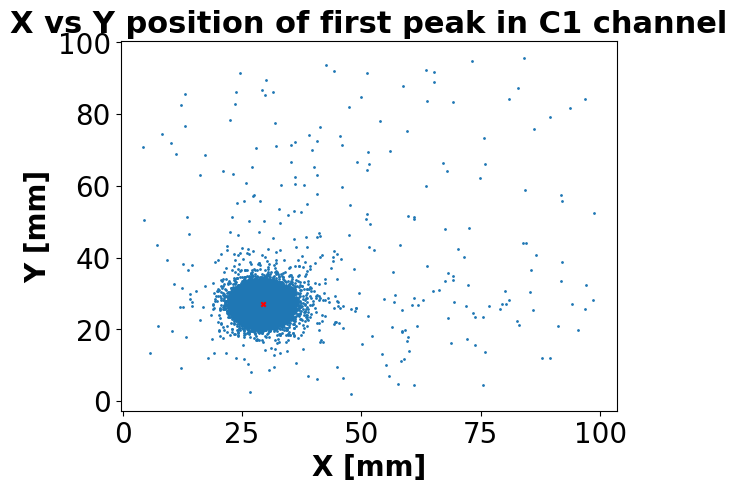

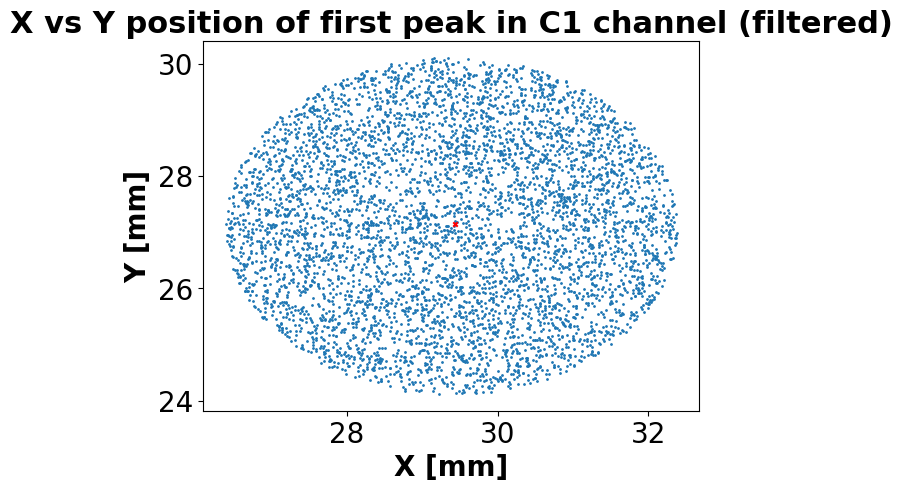

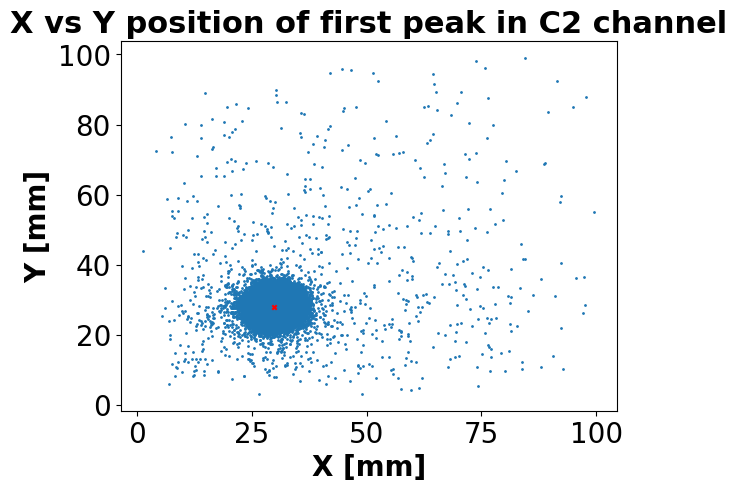

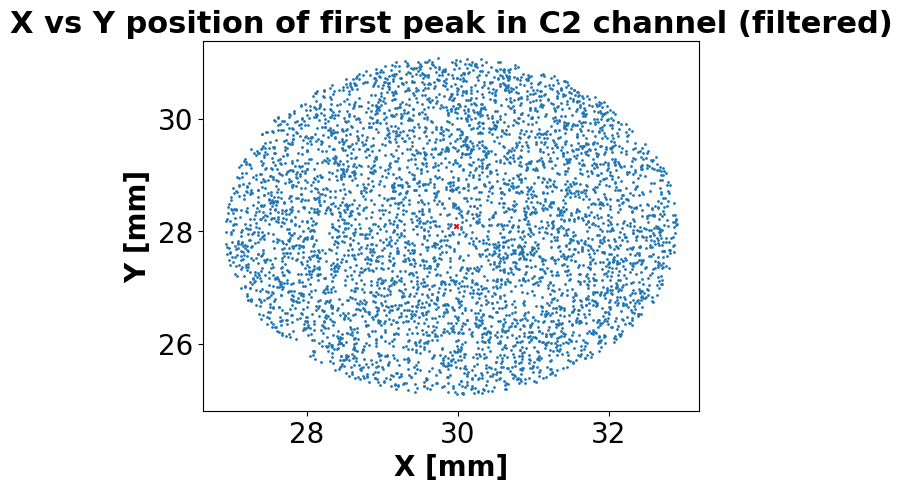

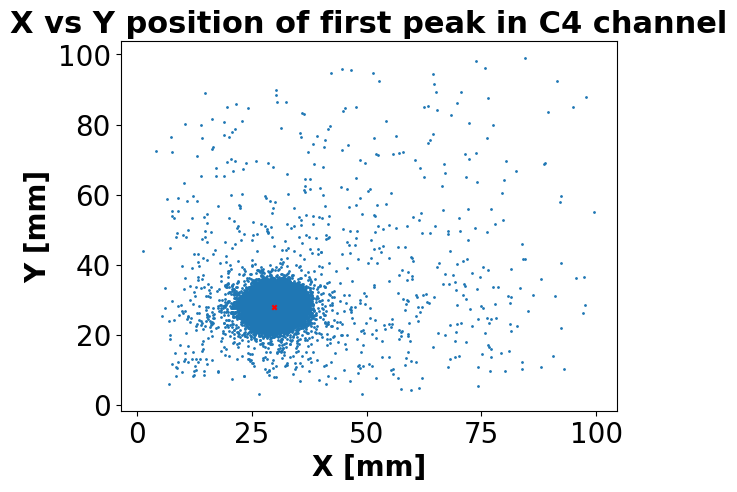

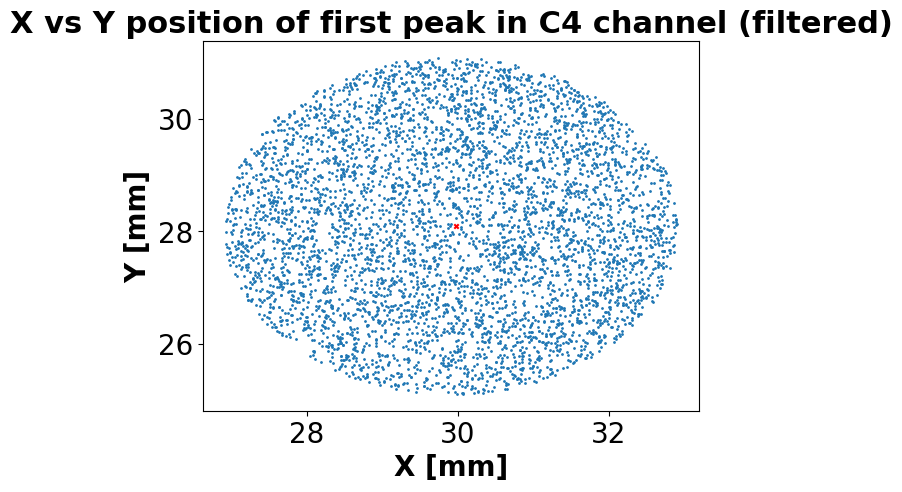

In [40]:
channels = ['C1', 'C2', 'C4']
filter_dict = {}
for channel in channels:
    first_c_xs = df[f'hitX_{channel}']
    first_c_xs = np.array(first_c_xs)
    first_c_ys = df[f'hitY_{channel}']
    first_c_ys = np.array(first_c_ys)

    xy_filter_cut = (first_c_xs > -100) & (first_c_xs < 100) & (first_c_ys > -100) & (first_c_ys < 100)

    first_c_xs_plt = first_c_xs[xy_filter_cut]
    median_x = np.median(first_c_xs_plt)

    first_c_ys_plt = first_c_ys[xy_filter_cut]
    median_y = np.median(first_c_ys_plt)

    fig, ax = plt.subplots()
    ax.scatter(first_c_xs_plt, first_c_ys_plt, s=1)
    ax.scatter(median_x, median_y, s=10, c='red', marker='x')
    ax.set_title(f'X vs Y position of first peak in {channel} channel')
    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')

    # Select events within 10 mm of the median
    r = np.sqrt((first_c_xs - median_x)**2 + (first_c_ys - median_y)**2)
    # filter = (1 < r) & (r < 3)
    filter = r < 3
    first_c_xs_filtered = first_c_xs[filter]
    first_c_ys_filtered = first_c_ys[filter]
    median_x = np.median(first_c_xs_filtered)
    median_y = np.median(first_c_ys_filtered)

    filter_dict.update({channel: filter})

    fig, ax = plt.subplots()
    ax.scatter(first_c_xs_filtered, first_c_ys_filtered, s=1)
    ax.scatter(median_x, median_y, s=10, c='red', marker='x')
    ax.set_title(f'X vs Y position of first peak in {channel} channel (filtered)')
    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')


plt.show()


C1 Number of outliers: 0 of 25984
C1 Number after filter: 25984 of 25984
C1 channel: min = 0.012497826801337581, max = 0.780148545889383
[False False False ... False False False]
C1 channel: min = 0.014984740229233559, max = 0.779766428866071
C2 Number of outliers: 4 of 25984
C2 Number after filter: 4984 of 25984
C2 channel: min = -1.1064713598079476e-16, max = 0.42080213151480894
[False False False ... False False False]
C2 channel: min = 0.002777489636064978, max = 0.3868780867235633
C4 Number of outliers: 6 of 25984
C4 Number after filter: 21775 of 25984
C4 channel: min = -4.059830067122186e-12, max = 0.4226190158390923
[False False False ... False False False]
C4 channel: min = 0.0012917159616351677, max = 0.4203665133910493


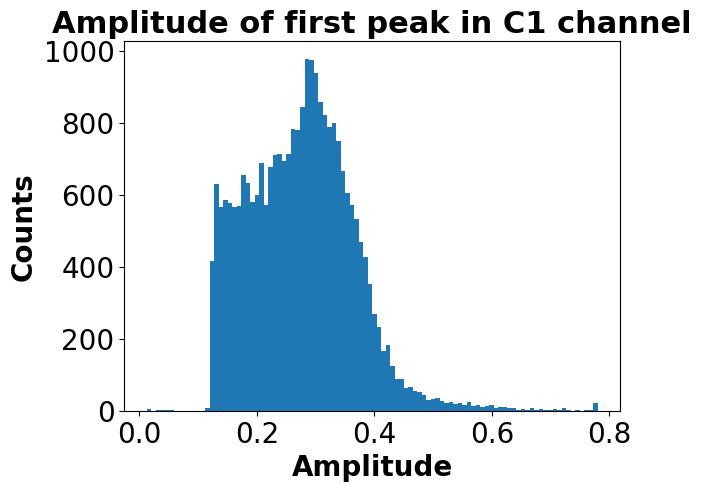

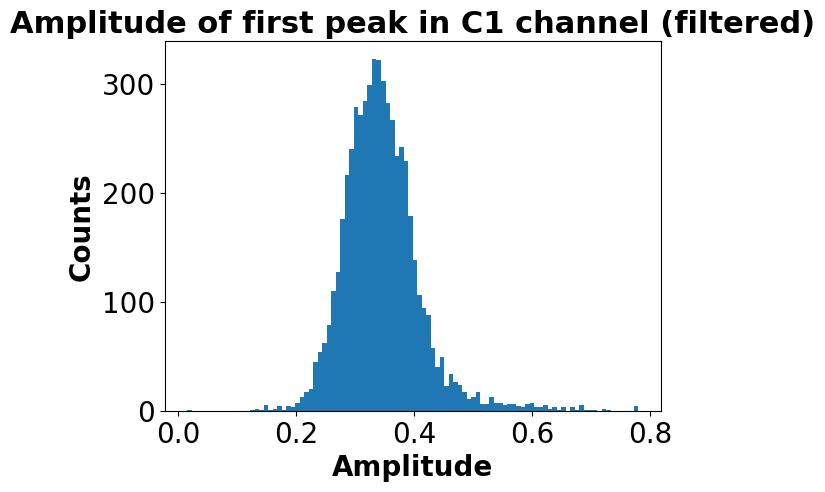

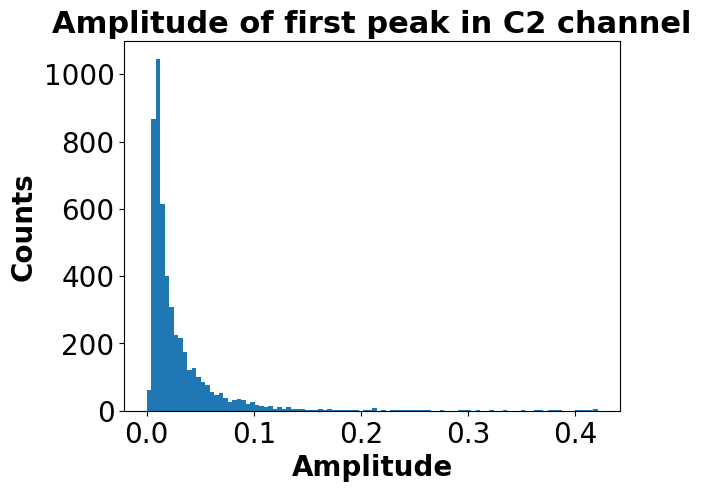

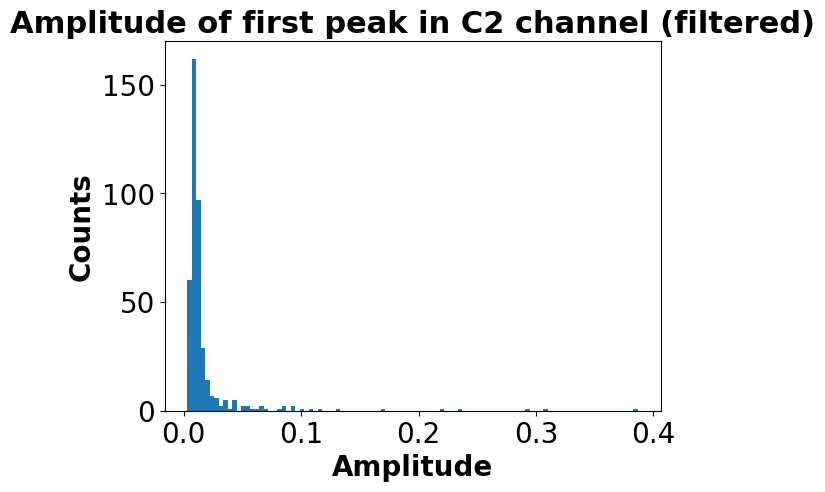

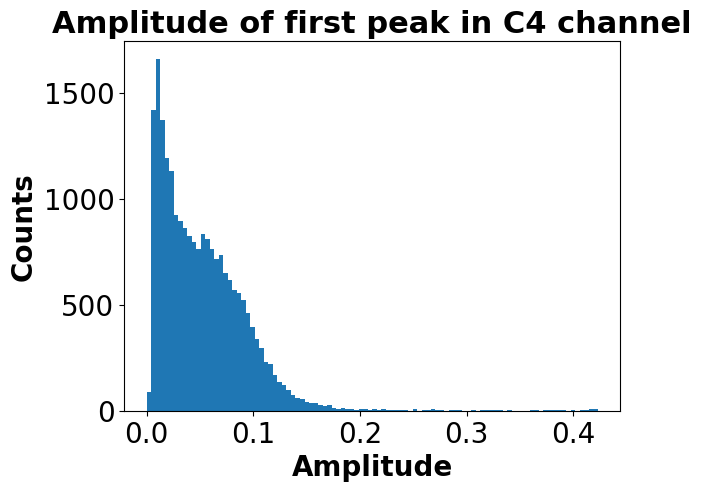

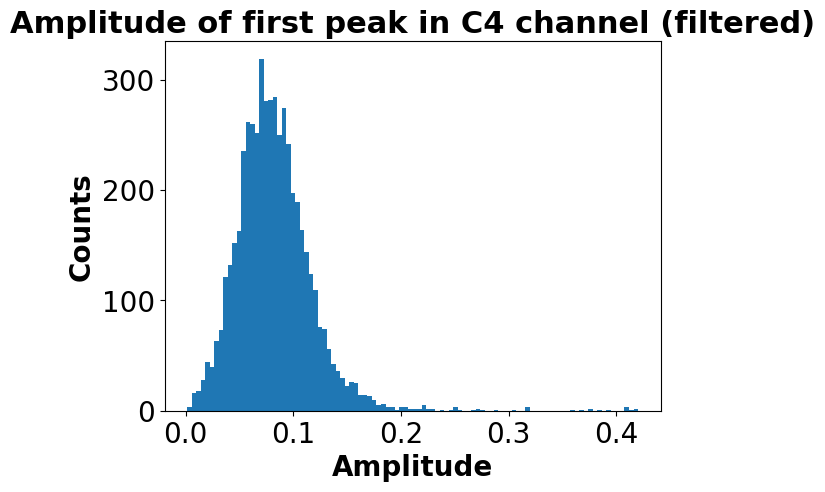

In [41]:
for channel in ['C1', 'C2', 'C4']:
    first_ampls = df[f'peakparam_{channel}/peakparam_{channel}.ampl']
    df[f'peakparam_{channel}/peakparam_{channel}.ampl_filtered'] = first_ampls.apply(lambda x: x if (x > min_ampl) & (x < max_ampl) else np.nan)
    first_ampls = np.array(first_ampls)
    first_ampls_filtered = first_ampls[(first_ampls > min_ampl) & (first_ampls < max_ampl)]
    first_ampls_outliers = first_ampls[(first_ampls < min_ampl) | (first_ampls > max_ampl)]
    # Update the dataframe with the filtered amplitudes

    print(f'{channel} Number of outliers: {len(first_ampls_outliers)} of {len(first_ampls)}')
    print(f'{channel} Number after filter: {len(first_ampls_filtered)} of {len(first_ampls)}')
    #plot each channels amplitude in a histogram
    #print range of amplitudes
    print(f'{channel} channel: min = {np.nanmin(first_ampls_filtered)}, max = {np.nanmax(first_ampls_filtered)}')
    fig, ax = plt.subplots()
    ax.hist(first_ampls_filtered, bins=100)
    ax.set_title(f'Amplitude of first peak in {channel} channel')
    ax.set_xlabel('Amplitude')
    ax.set_ylabel('Counts')

    print(filter_dict[channel])
    filtered_first_ampls = first_ampls[filter_dict[channel]]
    filtered_first_ampls = filtered_first_ampls[(filtered_first_ampls > min_ampl) & (filtered_first_ampls < max_ampl)]
    print(f'{channel} channel: min = {np.nanmin(filtered_first_ampls)}, max = {np.nanmax(filtered_first_ampls)}')
    fig, ax = plt.subplots()
    ax.hist(filtered_first_ampls, bins=100)
    ax.set_title(f'Amplitude of first peak in {channel} channel (filtered)')
    ax.set_xlabel('Amplitude')
    ax.set_ylabel('Counts')
plt.show()


C1 Number of outliers: 25984 of 25984
C2 Number of outliers: 1 of 25984
C2 channel: min = 0.004009692519903183, max = 0.386275645699352
C4 Number of outliers: 2 of 25984
C4 channel: min = 0.004107646364718673, max = 0.3864324754104018


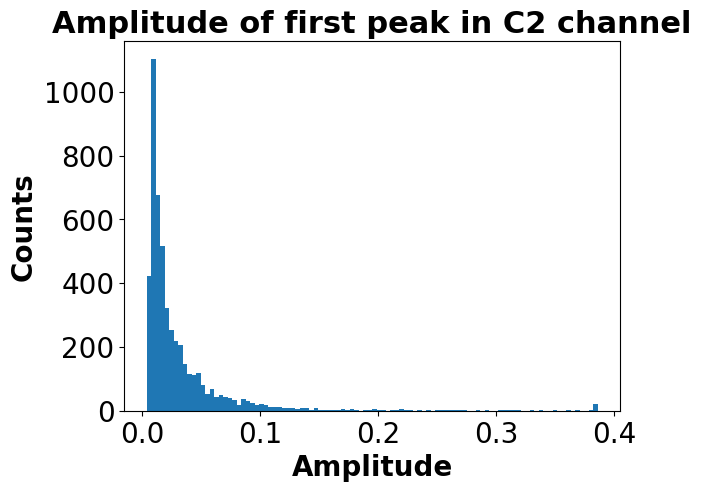

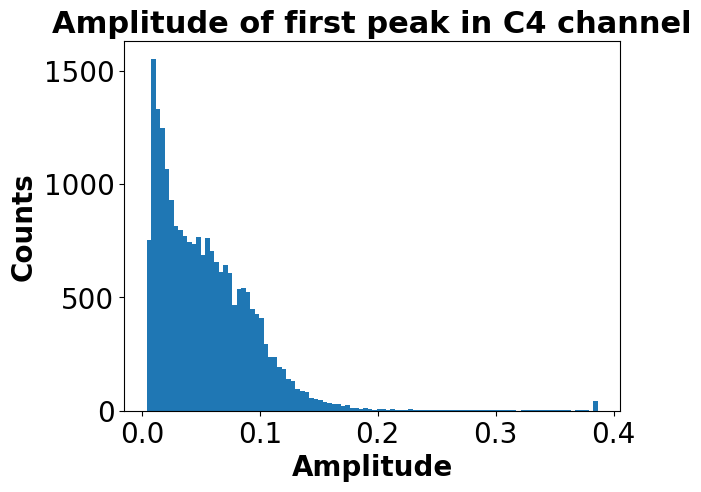

In [42]:
for channel in ['C1', 'C2', 'C4']:
    first_dampls = df[f'peakparam_{channel}/peakparam_{channel}.dampl']

    df[f'peakparam_{channel}/peakparam_{channel}.dampl_filtered'] = first_dampls.apply(lambda x: x if (x > min_ampl) & (x < max_ampl) else np.nan)
    first_dampls = np.array(first_dampls)
    first_dampls_filtered = first_dampls[(first_dampls > min_ampl) & (first_dampls < max_ampl)]
    first_dampls_outliers = first_dampls[(first_dampls < min_ampl) | (first_dampls > max_ampl)]
    print(f'{channel} Number of outliers: {len(first_dampls_outliers)} of {len(first_dampls)}')

    #plot each channels amplitude in a histogram
    #print range of amplitudes
    if len(first_dampls_filtered) <= 0: continue
    print(f'{channel} channel: min = {np.nanmin(first_dampls_filtered)}, max = {np.nanmax(first_dampls_filtered)}')
    fig, ax = plt.subplots()
    ax.hist(first_dampls_filtered, bins=100)
    ax.set_title(f'Amplitude of first peak in {channel} channel')
    ax.set_xlabel('Amplitude')
    ax.set_ylabel('Counts')
plt.show()

In [43]:
print(df.head())

        hitX_C1    hitY_C1  peakparam_C1/peakparam_C1.ampl  \
4416  35.293076  28.785038                        0.191332   
4417  25.653530  28.127159                        0.311535   
4418  26.117359  29.403099                        0.319465   
4419        NaN        NaN                        0.301462   
4420  31.524521  25.177364                        0.273322   

      peakparam_C1/peakparam_C1.dampl  peakparam_C1/peakparam_C1.charge  \
4416                           -999.0                          0.133860   
4417                           -999.0                          0.203303   
4418                           -999.0                          0.219874   
4419                           -999.0                          0.211156   
4420                           -999.0                          0.186704   

      peakparam_C1/peakparam_C1.echargefit  \
4416                               -9999.0   
4417                               -9999.0   
4418                               -99

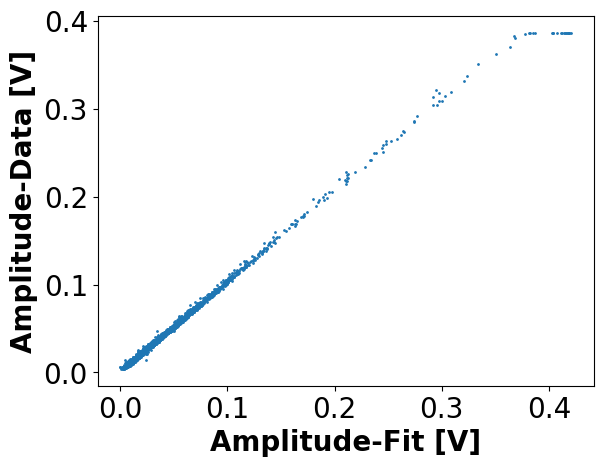

In [44]:
#correlation plot of amplitudes and damplitudes for channel C2 and C4
fig, ax = plt.subplots()
ax.scatter(df['peakparam_C2/peakparam_C2.ampl_filtered'], df['peakparam_C2/peakparam_C2.dampl_filtered'], s=1)
ax.set_title('')
ax.set_xlabel('Amplitude-Fit [V]')
ax.set_ylabel('Amplitude-Data [V]')
plt.show()

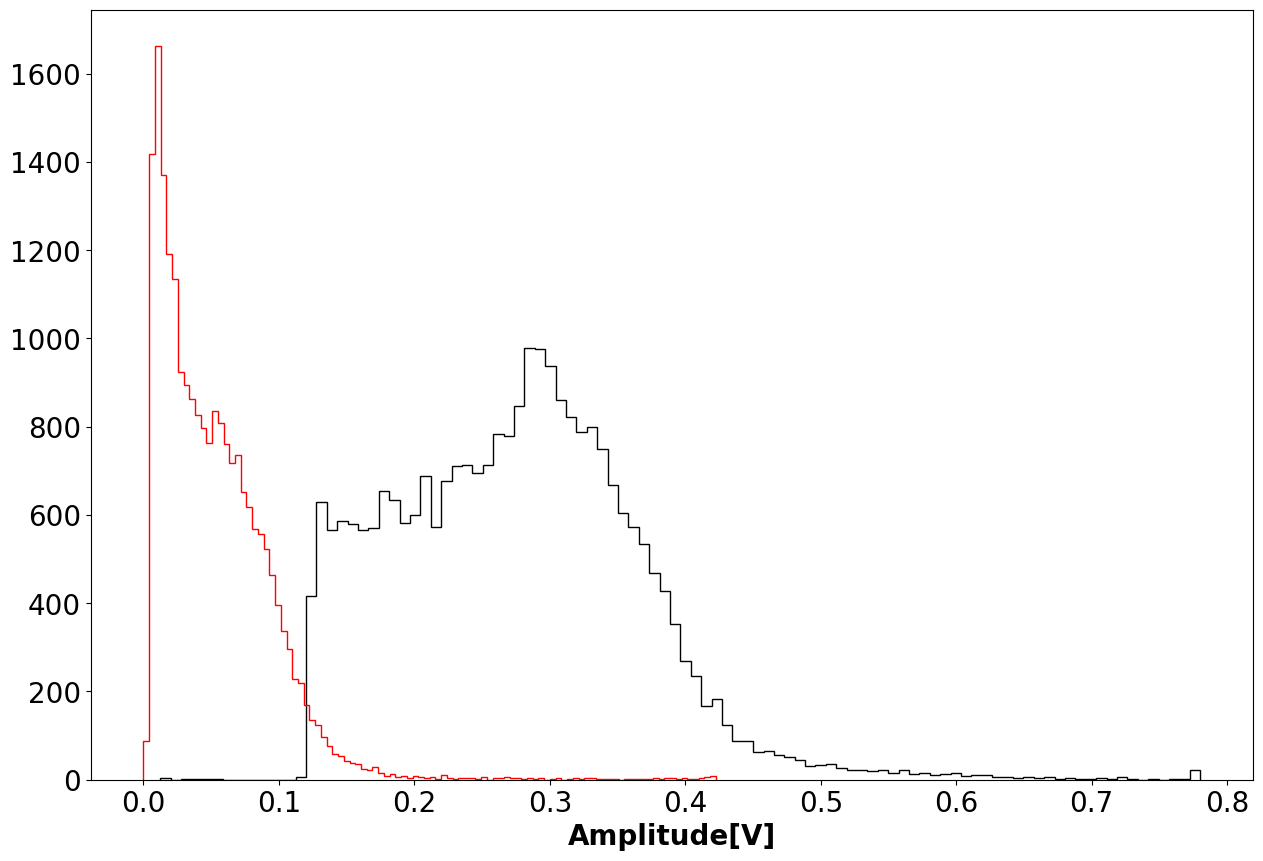

In [45]:
#make a plot with c1 and c4 amplitudes at the same graph
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(df['peakparam_C1/peakparam_C1.ampl_filtered'], bins=100, histtype='step', color='black', lw=2, label=f'MCP-1')
ax.hist(df['peakparam_C4/peakparam_C4.ampl_filtered'], bins=100, histtype='step', color='red', lw=2, label=f'MM-pad0')
ax.set_title('')
ax.set_xlabel('Amplitude[V]')
ax.set_ylabel('')
plt.show()


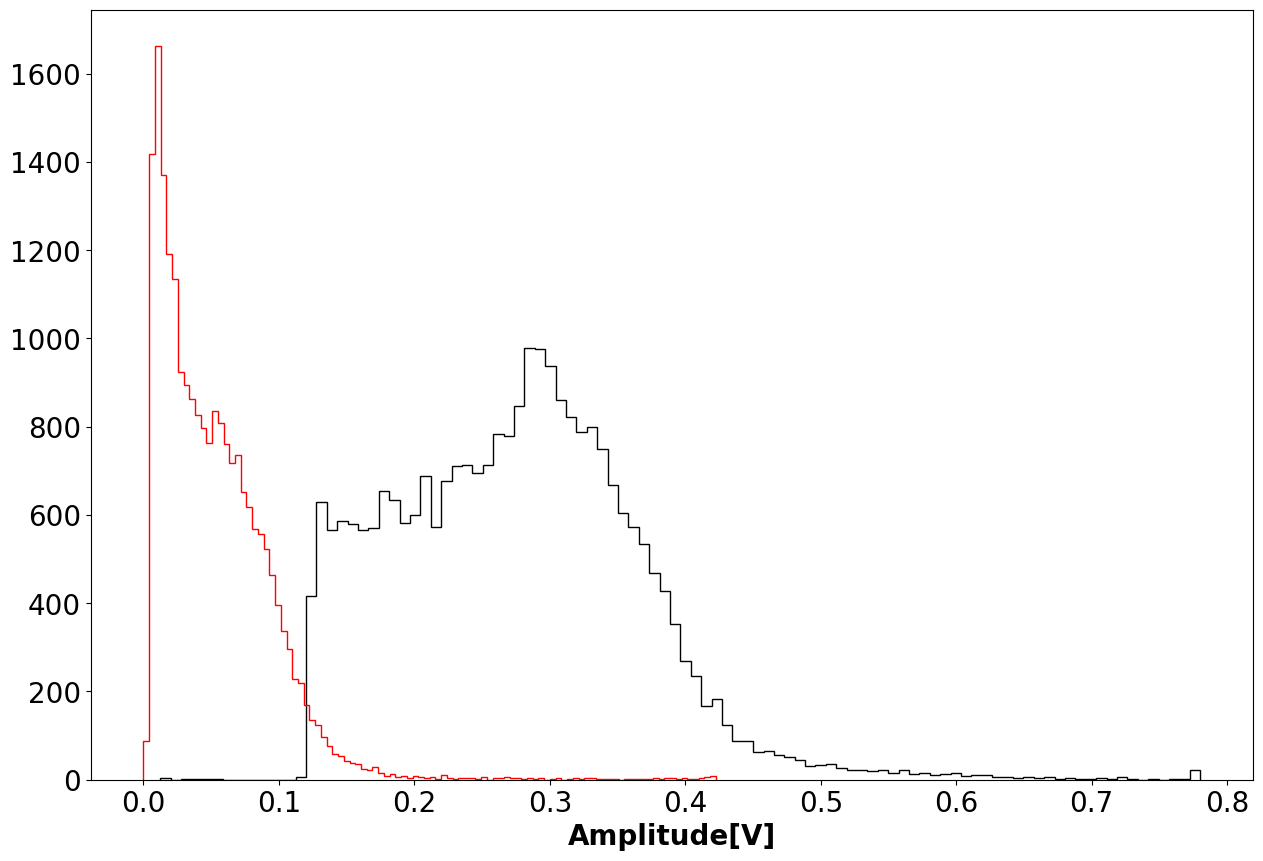

In [46]:
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(df['peakparam_C1/peakparam_C1.ampl_filtered'], bins=100, histtype='step', color='black', lw=2, label=f'MCP-1')
ax.hist(df['peakparam_C4/peakparam_C4.ampl_filtered'], bins=100, histtype='step', color='red', lw=2, label=f'MM-pad0')
ax.set_title('')
ax.set_xlabel('Amplitude[V]')
ax.set_ylabel('')
plt.show()

C1 Number of outliers: 0 of 25984
C1 Number after filter: 25984 of 25984
C1 channel: min = 0.0067010960068495315, max = 1.1877907654227633
C2 Number of outliers: 4 of 25984
C2 Number after filter: 4984 of 25984
C2 channel: min = -0.07276203386073572, max = 19.76272954189679
C4 Number of outliers: 10 of 25984
C4 Number after filter: 21771 of 25984
C4 channel: min = -0.3463519660040677, max = 19.931197633682842


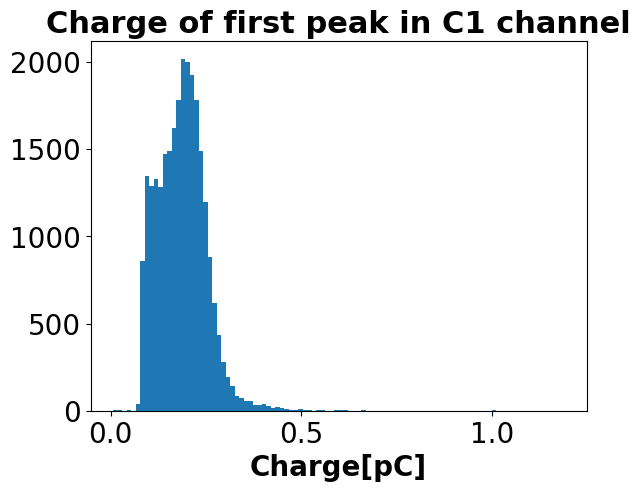

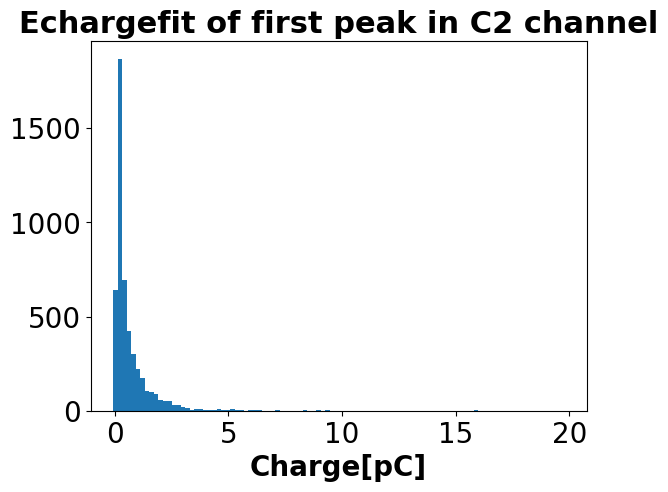

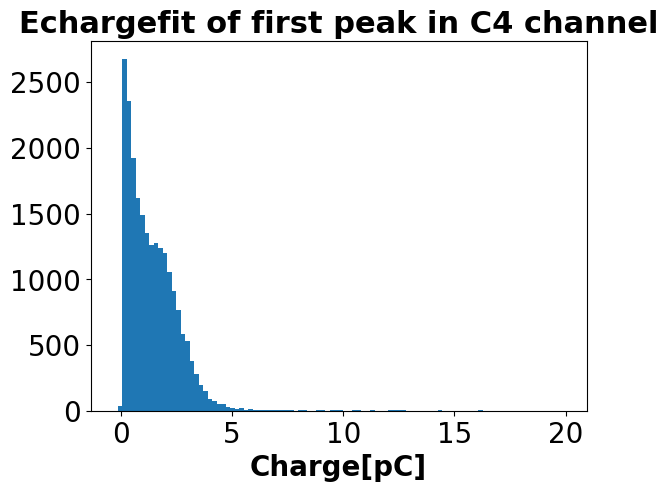

In [47]:
for channel in ['C1','C2', 'C4']:
    if channel == 'C1':
        first_charges = df[f'peakparam_{channel}/peakparam_{channel}.charge']
        df[f'peakparam_{channel}/peakparam_{channel}.charge_filtered'] = first_charges.apply(lambda x: x if (x > min_charge) & (x < max_charge) else np.nan)
        first_charges = np.array(first_charges)
        first_charges_filtered = first_charges[(first_charges > min_charge) & (first_charges < max_charge)]
        first_charges_outliers = first_charges[(first_charges< min_charge) | (first_charges > max_charge)]
    else:
        first_charges = df[f'peakparam_{channel}/peakparam_{channel}.echargefit']
        df[f'peakparam_{channel}/peakparam_{channel}.echargefit_filtered'] = first_charges.apply(lambda x: x if (x > min_charge) & (x < max_charge) else np.nan)

        first_charges = np.array(first_charges)
        first_charges_filtered = first_charges[(first_charges > min_charge) & (first_charges < max_charge)]
        first_charges_outliers = first_charges[(first_charges< min_charge) | (first_charges > max_charge)]
    # Update the dataframe with the filtered amplitudes

    print(f'{channel} Number of outliers: {len(first_charges_outliers)} of {len(first_charges)}')
    print(f'{channel} Number after filter: {len(first_charges_filtered)} of {len(first_charges)}')
    #plot each channels amplitude in a histogram
    #print range of amplitudes
    print(f'{channel} channel: min = {np.nanmin(first_charges_filtered)}, max = {np.nanmax(first_charges_filtered)}')
    fig, ax = plt.subplots()
    ax.hist(first_charges_filtered, bins=100)
    if channel == 'C1':
        ax.set_title(f'Charge of first peak in {channel} channel')
    else:
        ax.set_title(f'Echargefit of first peak in {channel} channel')
    ax.set_xlabel('Charge[pC]')
    ax.set_ylabel('')
plt.show()

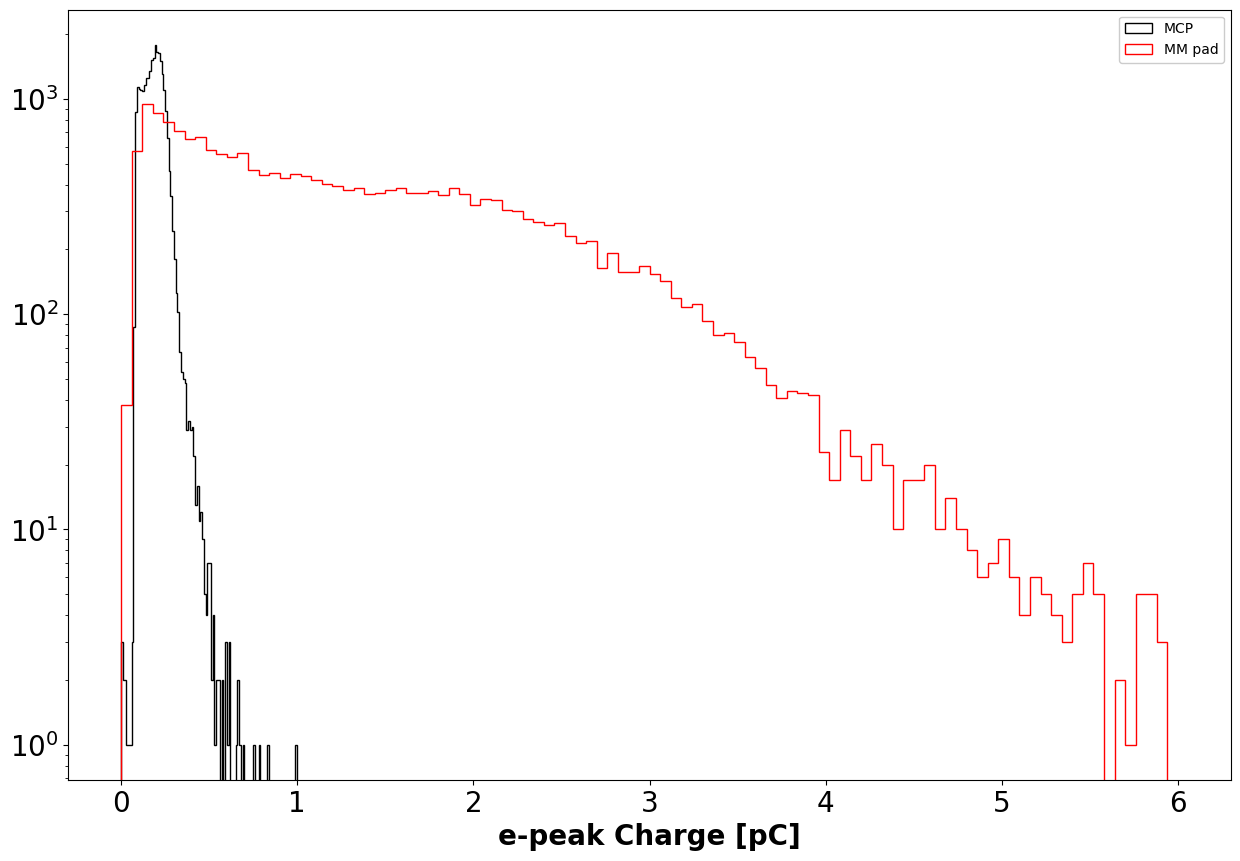

In [48]:
fig, axs = plt.subplots(figsize=(15, 10))
#for i in range(len(mcp_qs)):
axs.hist(df[f'peakparam_C1/peakparam_C1.charge_filtered'], bins=100, range=(0.0, 1.0), histtype='step', color='black', lw=2, label=f'MCP')
axs.hist(df[f'peakparam_C4/peakparam_C4.echargefit_filtered'], bins=100, range=(0.0, 6.0), histtype='step', color='red', lw=2, label=f'MM pad')
axs.set_yscale('log')
axs.set_xlabel('e-peak Charge [pC]')
axs.set_title('')
axs.legend()
plt.show()

C1 Number of outliers: 0 of 25984
C1 Number after filter: 25984 of 25984
C1 channel: min = 0.0067010960068495315, max = 1.1877907654227633
C2 Number of outliers: 21 of 25984
C2 Number after filter: 4967 of 25984
C2 channel: min = 0.13149981795361282, max = 48.99145113336151
C4 Number of outliers: 48 of 25984
C4 Number after filter: 21733 of 25984
C4 channel: min = 0.20159773797738173, max = 49.8734070391704


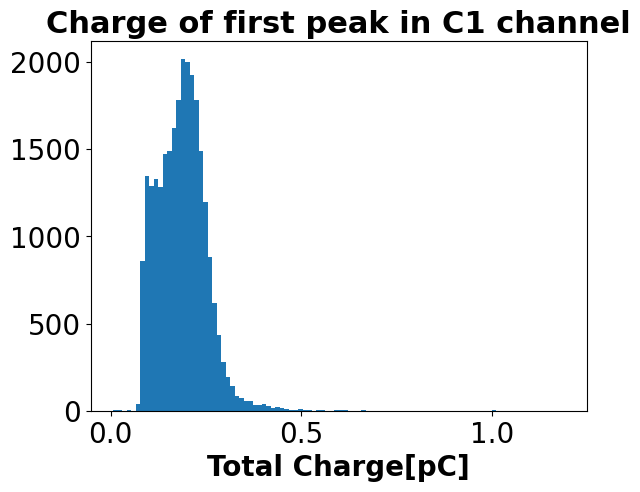

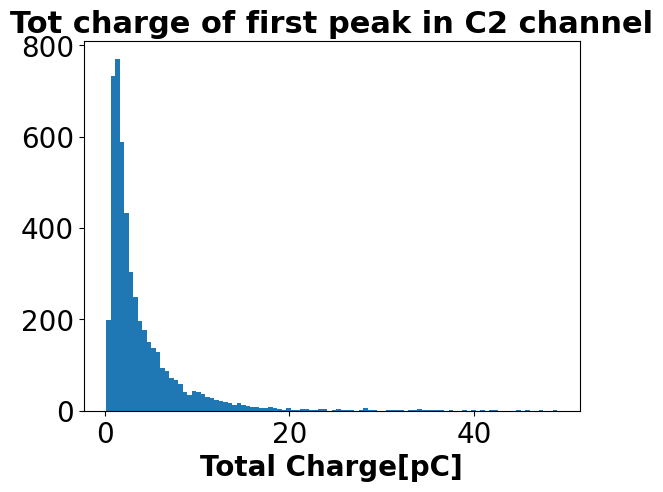

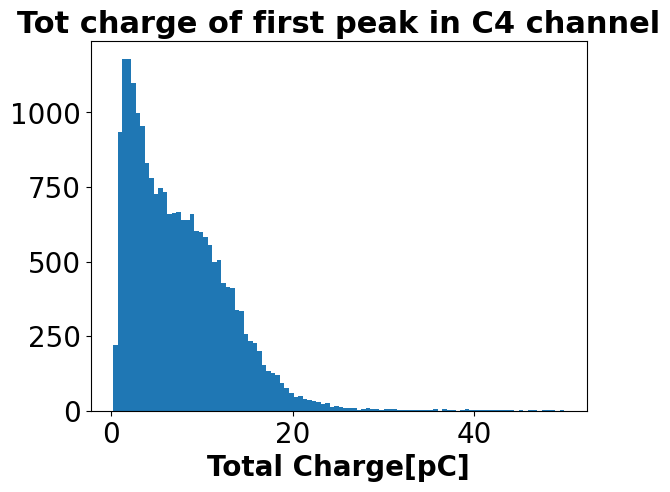

In [49]:
for channel in ['C1','C2', 'C4']:
    if channel == 'C1':
        first_charges = df[f'peakparam_{channel}/peakparam_{channel}.charge']
        df[f'peakparam_{channel}/peakparam_{channel}.charge_filtered'] = first_charges.apply(lambda x: x if (x > min_charge_tot) & (x < max_charge_tot) else np.nan)
        first_charges = np.array(first_charges)
        first_charges_filtered = first_charges[(first_charges > min_charge_tot) & (first_charges < max_charge_tot)]
        first_charges_outliers = first_charges[(first_charges< min_charge_tot) | (first_charges > max_charge_tot)]
    else:
        first_charges = df[f'peakparam_{channel}/peakparam_{channel}.totcharge']
        df[f'peakparam_{channel}/peakparam_{channel}.totcharge_filtered'] = first_charges.apply(lambda x: x if (x > min_charge_tot) & (x < max_charge_tot) else np.nan)

        first_charges = np.array(first_charges)
        first_charges_filtered = first_charges[(first_charges > min_charge_tot) & (first_charges < max_charge_tot)]
        first_charges_outliers = first_charges[(first_charges< min_charge_tot) | (first_charges > max_charge_tot)]
    # Update the dataframe with the filtered amplitudes

    print(f'{channel} Number of outliers: {len(first_charges_outliers)} of {len(first_charges)}')
    print(f'{channel} Number after filter: {len(first_charges_filtered)} of {len(first_charges)}')
    #plot each channels amplitude in a histogram
    #print range of amplitudes
    print(f'{channel} channel: min = {np.nanmin(first_charges_filtered)}, max = {np.nanmax(first_charges_filtered)}')
    fig, ax = plt.subplots()
    ax.hist(first_charges_filtered, bins=100)
    if channel == 'C1':
        ax.set_title(f'Charge of first peak in {channel} channel')
    else:
        ax.set_title(f'Tot charge of first peak in {channel} channel')
    ax.set_xlabel('Total Charge[pC]')
    ax.set_ylabel('')
plt.show()

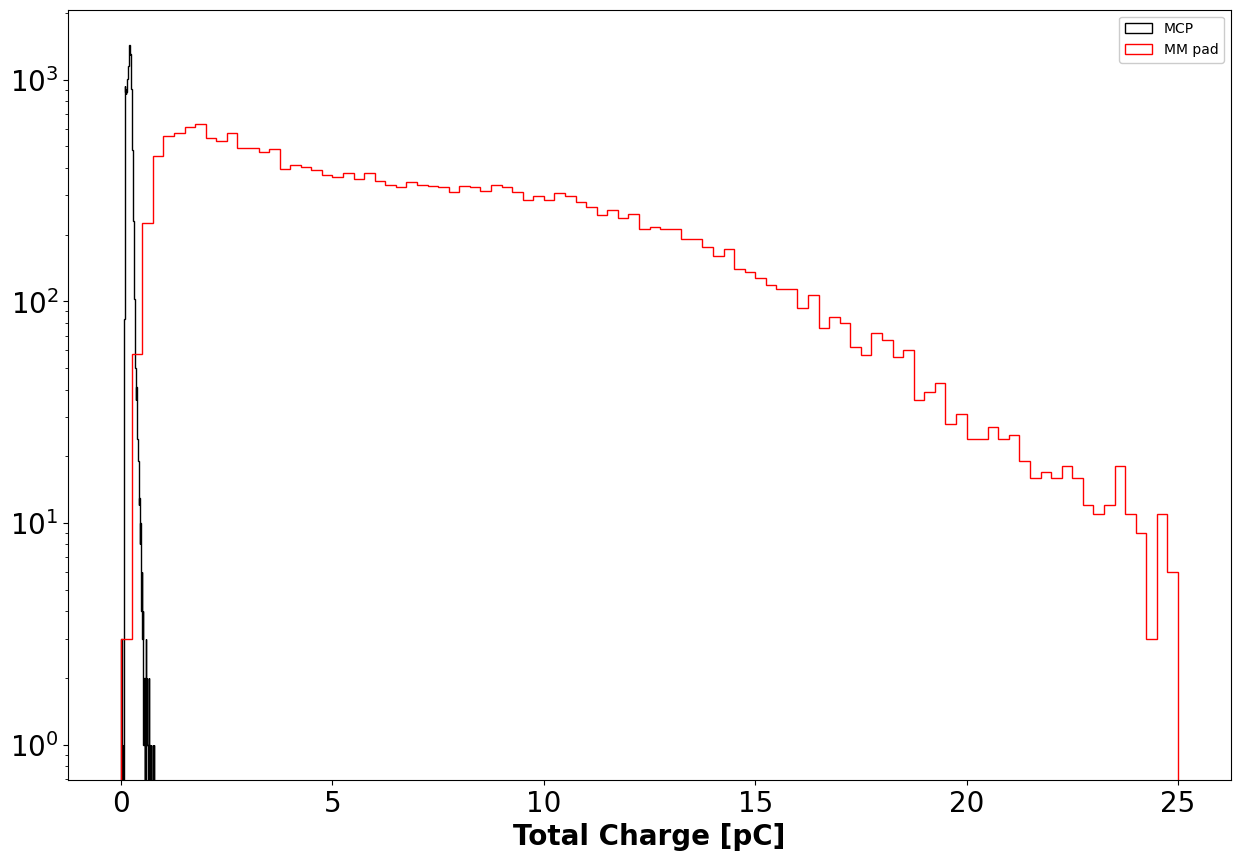

In [50]:
fig, axs = plt.subplots(figsize=(15, 10))
#for i in range(len(mcp_qs)):
axs.hist(df[f'peakparam_C1/peakparam_C1.charge_filtered'], bins=100, range=(0.0, 0.8), histtype='step', color='black', lw=2, label=f'MCP')
axs.hist(df[f'peakparam_C4/peakparam_C4.totcharge_filtered'], bins=100, range=(0.0, 25.0), histtype='step', color='red', lw=2, label=f'MM pad')
axs.set_yscale('log')
axs.set_xlabel('Total Charge [pC]')
axs.set_title('')
axs.legend()
plt.show()

Up Rejects:
        hitX_C1    hitY_C1  peakparam_C1/peakparam_C1.ampl  \
4444  27.797491  23.943296                        0.458306   
4492  24.579620  28.040747                        0.237517   
4504  34.008106  24.337193                        0.306263   
4517  28.840000  27.333103                        0.371106   
4521  28.431326  20.973377                        0.147619   

      peakparam_C1/peakparam_C1.dampl  peakparam_C1/peakparam_C1.charge  \
4444                           -999.0                          0.317773   
4492                           -999.0                          0.161774   
4504                           -999.0                          0.204402   
4517                           -999.0                          0.244336   
4521                           -999.0                          0.102539   

      peakparam_C1/peakparam_C1.echargefit  \
4444                               -9999.0   
4492                               -9999.0   
4504                      

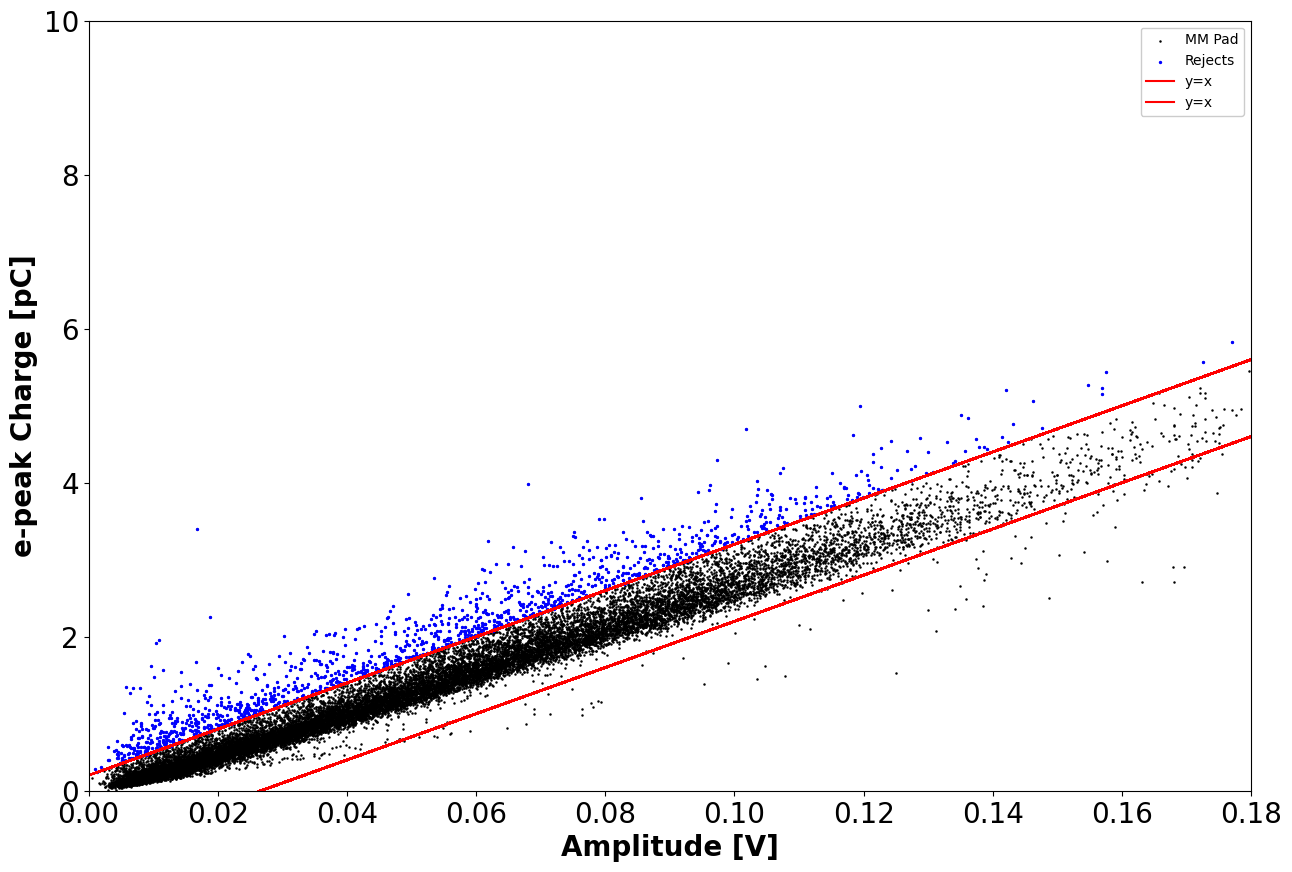

In [51]:
fig, axs = plt.subplots(figsize=(15, 10))

def line(x, a, b):
    return a*x + b

x = df[f'peakparam_C4/peakparam_C4.ampl_filtered']
y = df[f'peakparam_C4/peakparam_C4.echargefit_filtered']

up_slope, up_offset = 30, 0.2
up_rejects_filter = y > line(x, up_slope, up_offset)
up_rejects_x = x[up_rejects_filter]
up_rejects_y = y[up_rejects_filter]

up_rejects_df = df[up_rejects_filter]
print('Up Rejects:')
print(up_rejects_df.head())

#for i in range(len(mm_vs)):
axs.scatter(df[f'peakparam_C4/peakparam_C4.ampl_filtered'], df[f'peakparam_C4/peakparam_C4.echargefit_filtered'], s=0.6, color='black', label=f'MM Pad')
axs.scatter(up_rejects_x, up_rejects_y, s=2, color='blue', label=f'Rejects')
axs.plot(np.array(df[f'peakparam_C4/peakparam_C4.ampl_filtered']), line(np.array(df[f'peakparam_C4/peakparam_C4.ampl_filtered']), 30, 0.2), color='red', label='y=x')
axs.plot(df[f'peakparam_C4/peakparam_C4.ampl_filtered'], line(df[f'peakparam_C4/peakparam_C4.ampl_filtered'], 30, -0.8), color='red', label='y=x')

axs.set_xlabel('Amplitude [V]')
axs.set_ylabel('e-peak Charge [pC]')
axs.set_xlim(0, 0.18)
axs.set_ylim(0, 10)
axs.legend()

plt.show()

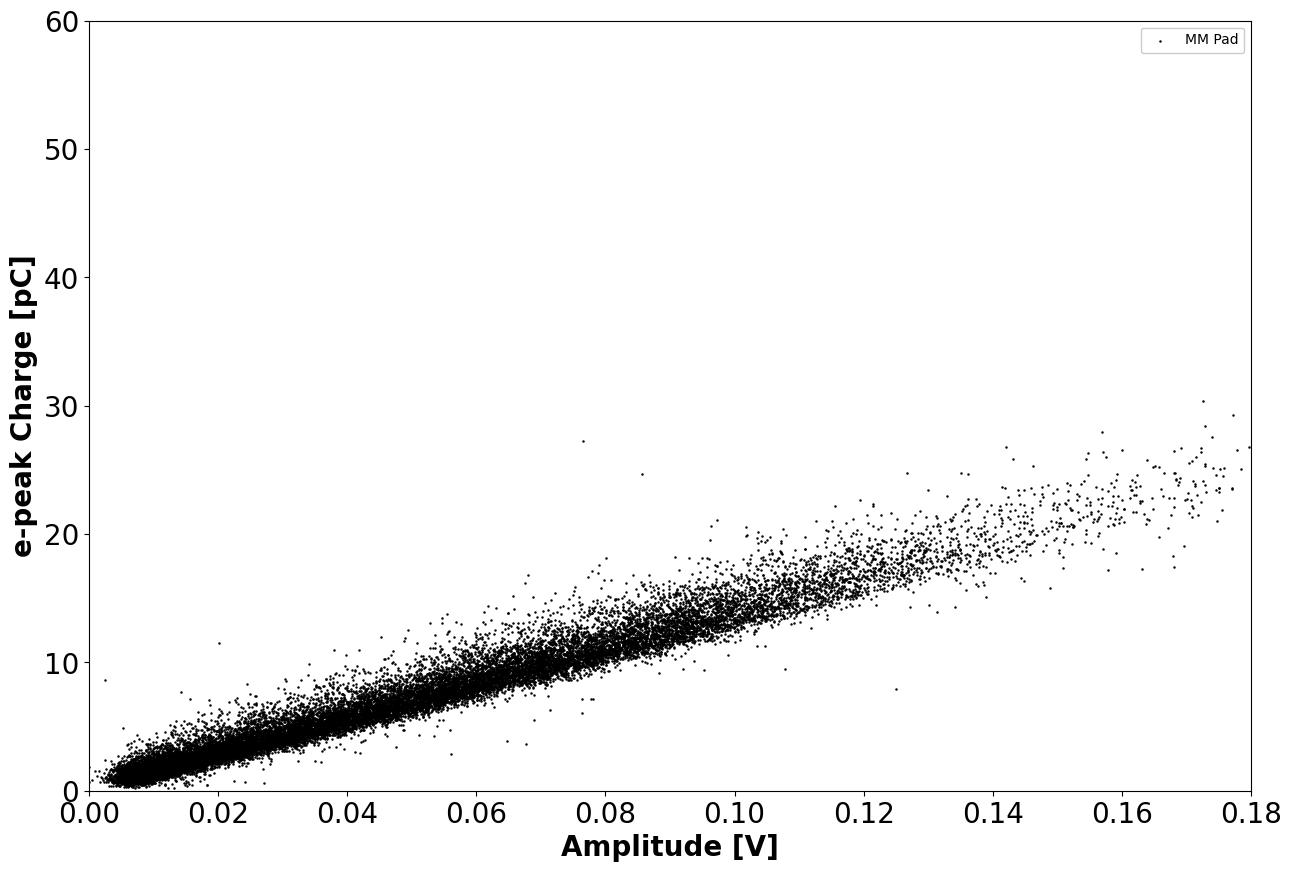

In [52]:
fig, axs = plt.subplots(figsize=(15, 10))

#for i in range(len(mm_vs)):
axs.scatter(df[f'peakparam_C4/peakparam_C4.ampl_filtered'], df[f'peakparam_C4/peakparam_C4.totcharge_filtered'], s=0.6, color='black', label=f'MM Pad')

axs.set_xlabel('Amplitude [V]')
axs.set_ylabel('e-peak Charge [pC]')
axs.set_xlim(0, 0.18)
axs.set_ylim(0, 60)
axs.legend()

plt.show()

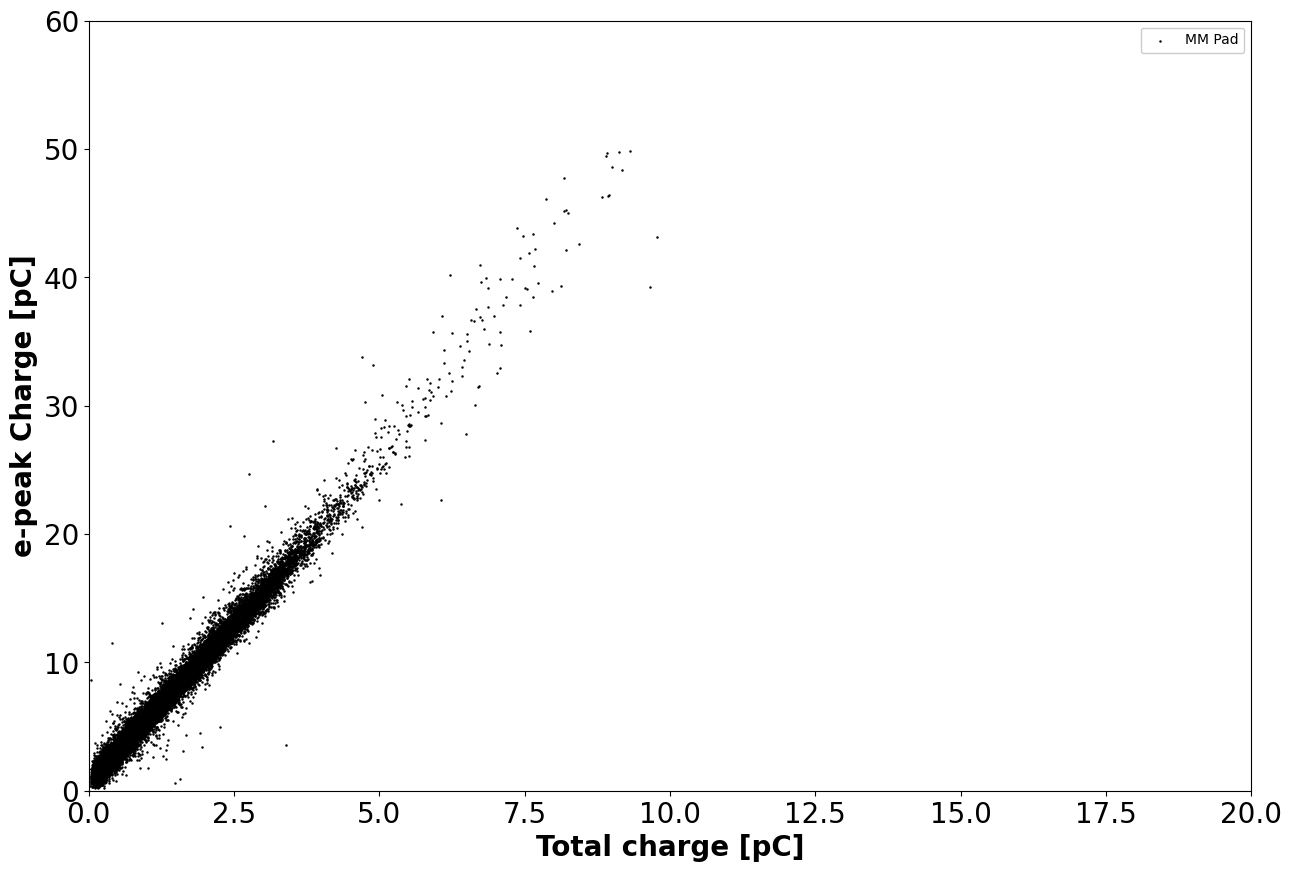

In [53]:
fig, axs = plt.subplots(figsize=(15, 10))

#for i in range(len(mm_vs)):
axs.scatter(df[f'peakparam_C4/peakparam_C4.echargefit_filtered'], df[f'peakparam_C4/peakparam_C4.totcharge_filtered'], s=0.6, color='black', label=f'MM Pad')

axs.set_xlabel('Total charge [pC]')
axs.set_ylabel('e-peak Charge [pC]')
axs.set_xlim(0, 20)
axs.set_ylim(0, 60)
axs.legend()

plt.show()

4416     35.293076
4417     25.653530
4418     26.117359
4419           NaN
4420     31.524521
           ...    
30395    29.106817
30396    29.552073
30397    34.347374
30398    33.680374
30399    27.692238
Name: hitX_C1, Length: 25946, dtype: float64


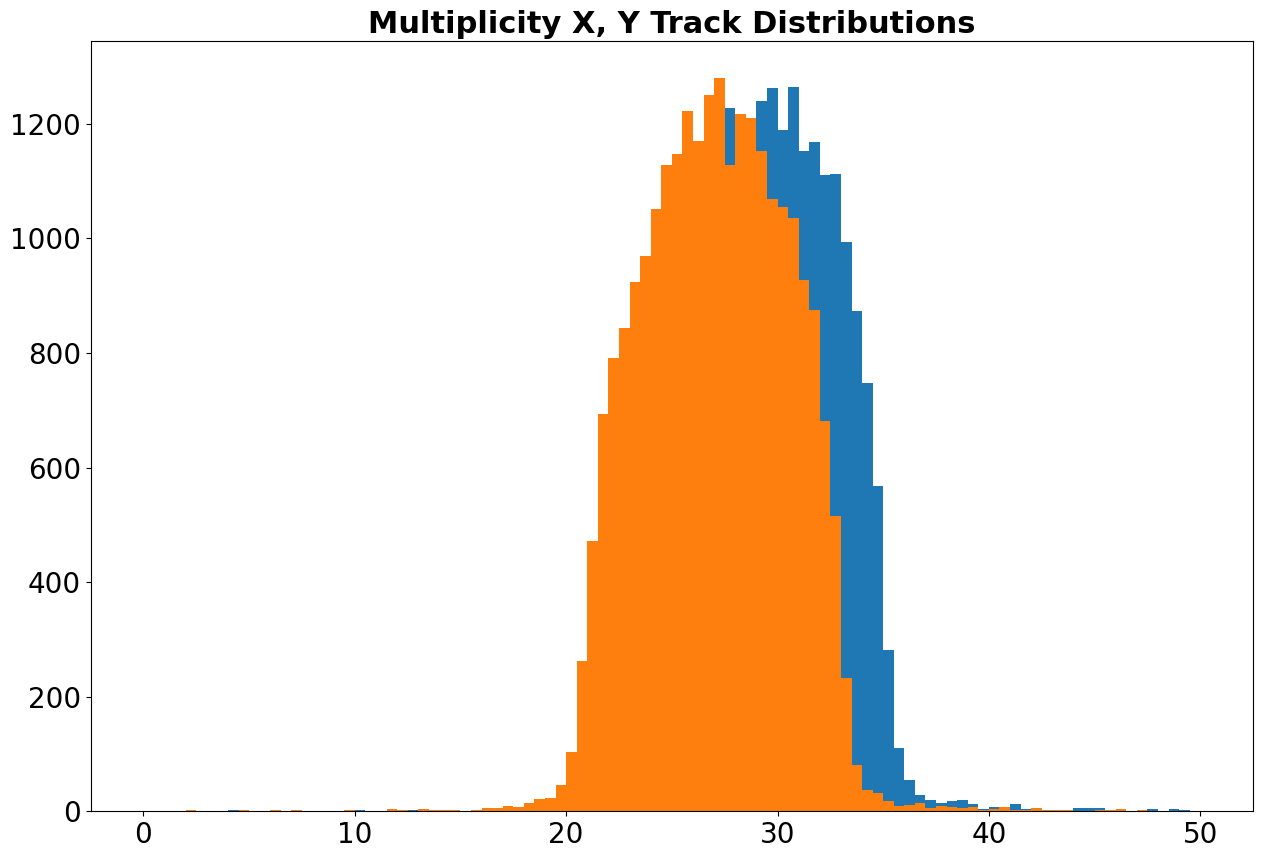

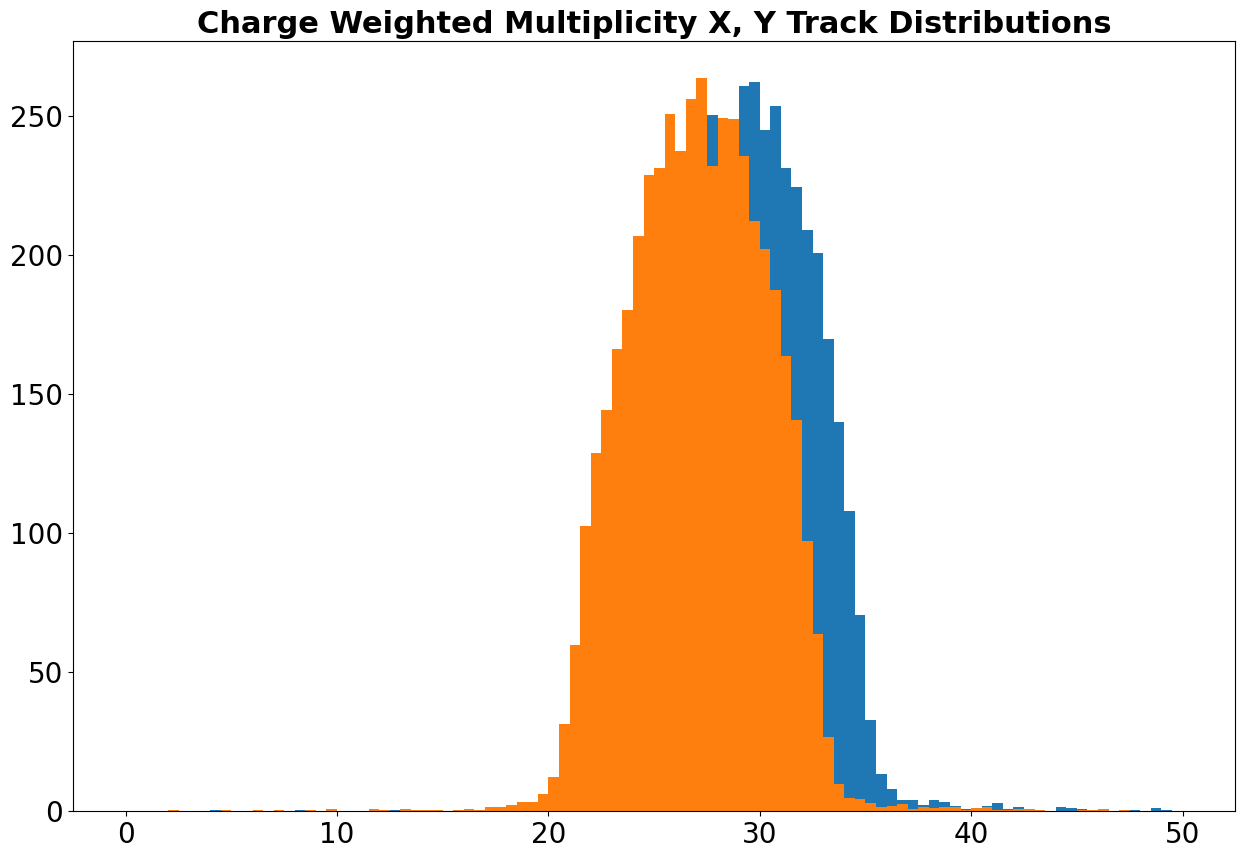

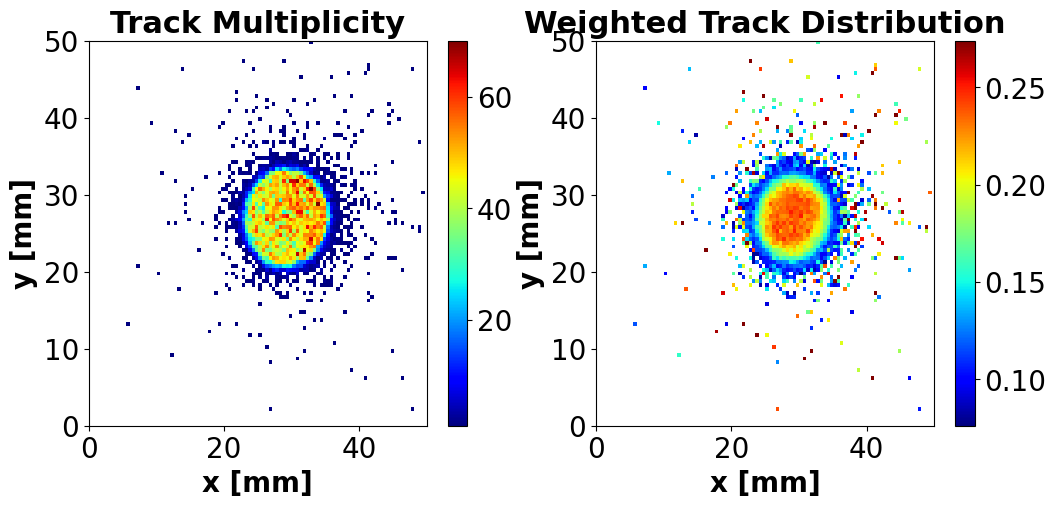

In [54]:
mcp_basic_charge_cut = (0 < df['peakparam_C1/peakparam_C1.charge_filtered']) & (df['peakparam_C1/peakparam_C1.charge_filtered'] < 0.5)
xs = df['hitX_C1'][mcp_basic_charge_cut]
ys = df['hitY_C1'][mcp_basic_charge_cut]
charges = df['peakparam_C1/peakparam_C1.charge_filtered'][mcp_basic_charge_cut]

print(xs)

# Define histogram bins
bins_x = np.linspace(0, 50, 101)  # 100 bins from 0 to 50
bins_y = np.linspace(0, 50, 101)

# Create 2D histogram (track multiplicity)
xytrks, _, _ = np.histogram2d(xs, ys, bins=[bins_x, bins_y])

# Create weighted histogram
xytrksW, _, _ = np.histogram2d(xs, ys, bins=[bins_x, bins_y], weights=charges)

# Normalize by dividing the weighted histogram by the original histogram
xytrksW /= np.where(xytrks > 0, xytrks, 1)  # Avoid division by zero

# Plot the results

# Mask xytrks <1
masked_xy_trks = np.ma.masked_less(xytrks, 1)
masked_xy_trksW = np.ma.masked_equal(xytrksW, 0)

# Plot 1D of xs
fig, ax = plt.subplots(figsize=(15, 10))
ax.hist(xs, bins=bins_x)
ax.hist(ys, bins=bins_y)
ax.set_title('Multiplicity X, Y Track Distributions')

# Plot 1D of xs and ys weighted by charge
fig, ax = plt.subplots(figsize=(15, 10))
ax.hist(xs, bins=bins_x, weights=charges)
ax.hist(ys, bins=bins_y, weights=charges)
ax.set_title('Charge Weighted Multiplicity X, Y Track Distributions')

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot xytrks
im1 = axs[0].imshow(masked_xy_trks.T, origin="lower", extent=[0, 50, 0, 50], cmap='jet', aspect="auto")
axs[0].set_title("Track Multiplicity")
axs[0].set_xlabel("x [mm]")
axs[0].set_ylabel("y [mm]")
fig.colorbar(im1, ax=axs[0])

# Plot xytrksW
im2 = axs[1].imshow(masked_xy_trksW.T, origin="lower", extent=[0, 50, 0, 50], cmap='jet', aspect="auto", vmax=np.max(masked_xy_trksW) / 1.8)
axs[1].set_title("Weighted Track Distribution")
axs[1].set_xlabel("x [mm]")
axs[1].set_ylabel("y [mm]")
fig.colorbar(im2, ax=axs[1])

In [55]:
print(get_pad_center(df, 'C4', plot=False, charge_cut_low=0, charge_cut_high=100))

([29.121 ± 0.040, 11.27 ± 0.15, -0.270 ± 0.032, -0.0002 ± 0.0013], [26.626 ± 0.048, 11.17 ± 0.15, -0.264 ± 0.030, 0.0006 ± 0.0012])


([29.121 ± 0.040, 11.27 ± 0.15, -0.270 ± 0.032, -0.0002 ± 0.0013], [26.626 ± 0.048, 11.17 ± 0.15, -0.264 ± 0.030, 0.0006 ± 0.0012])


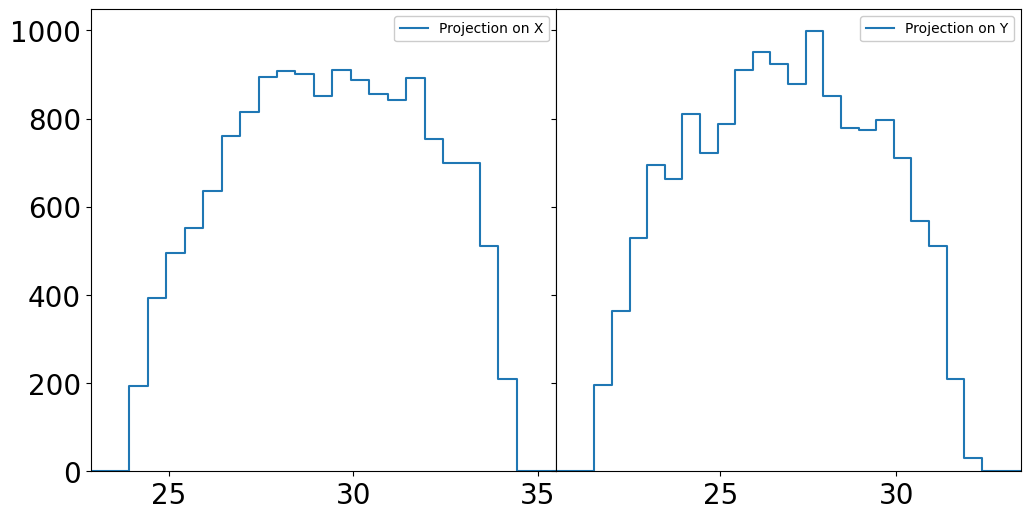

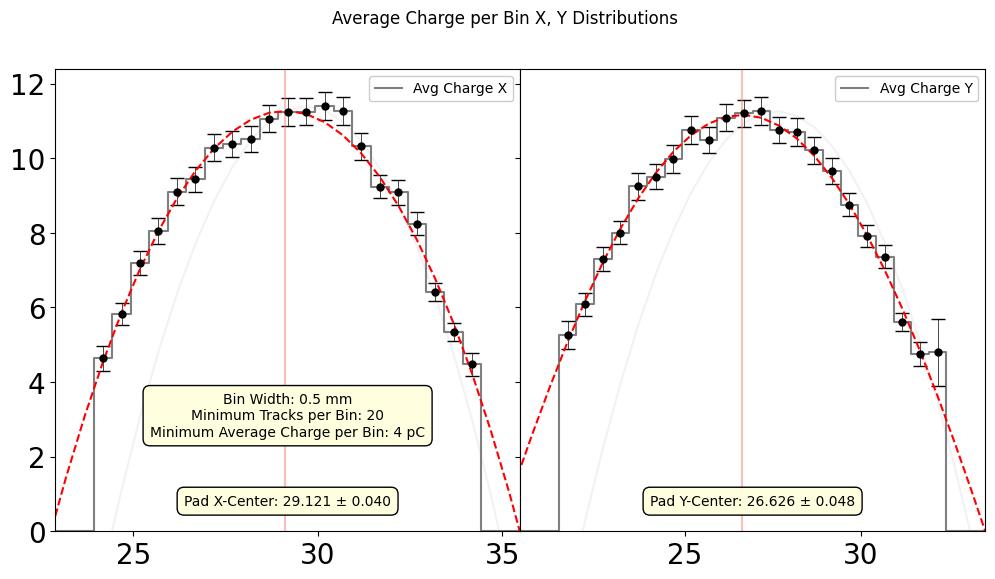

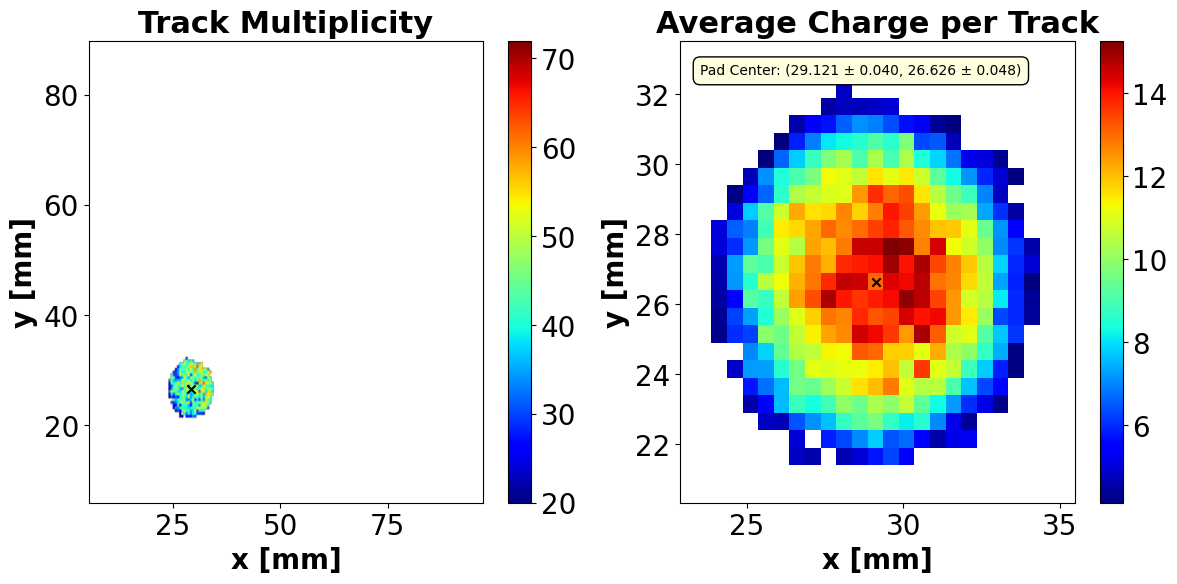

In [56]:
print(get_pad_center(df, 'C4', plot=True, charge_cut_low=0, charge_cut_high=100))

In [57]:
from scipy.optimize import curve_fit as cf
from TriggerEvaluation.Measure import Measure
def poly_even_fit(x, x0, a, b, c):
    return a + b * (x - x0)**2 + c * (x - x0)**4

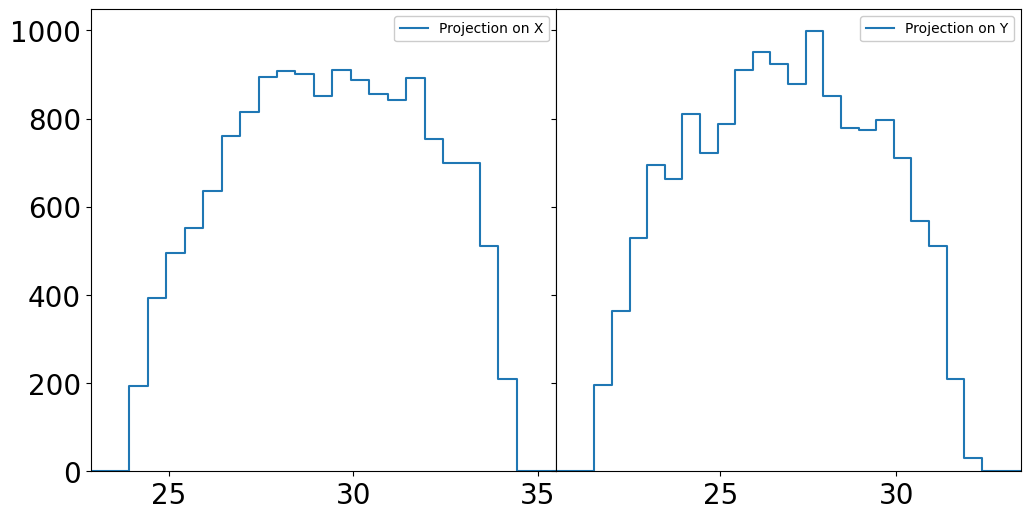

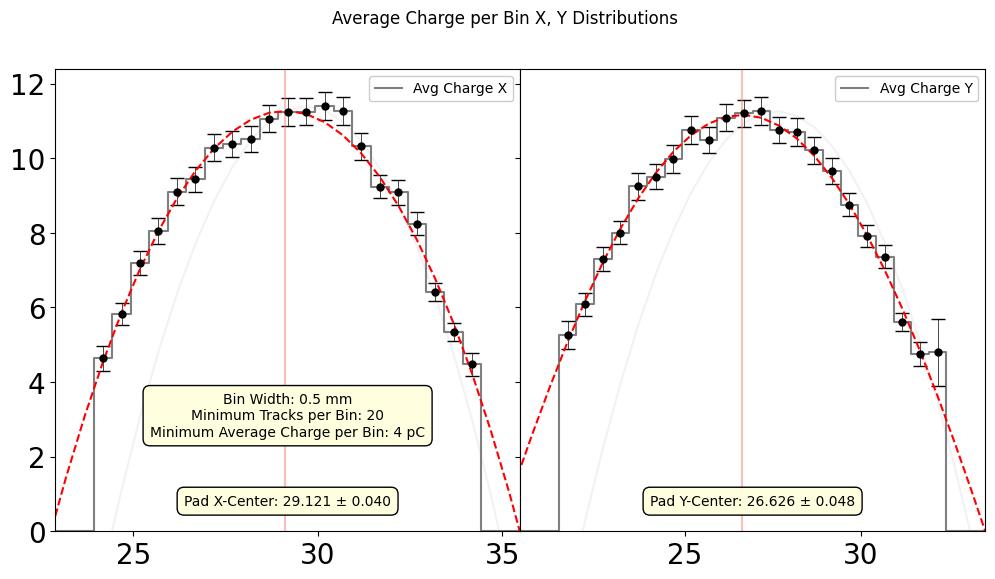

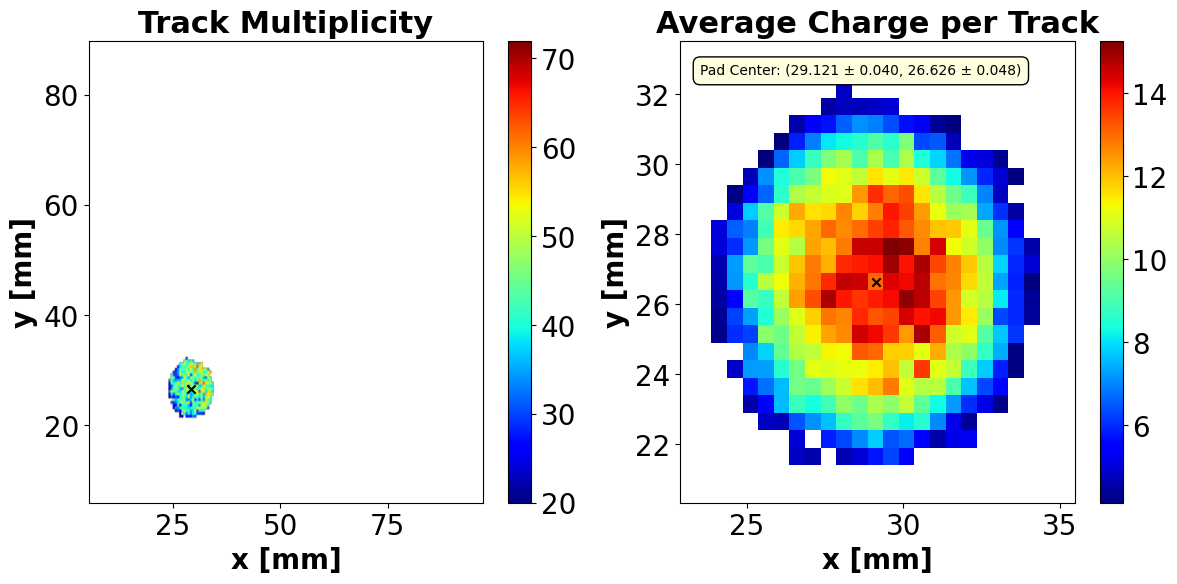

In [58]:
mm_basic_charge_cut = (0 < df['peakparam_C4/peakparam_C4.totcharge_filtered']) & (df['peakparam_C4/peakparam_C4.totcharge_filtered'] < 100)
xs = df['hitX_C4'][mm_basic_charge_cut]
ys = df['hitY_C4'][mm_basic_charge_cut]
charges = df['peakparam_C4/peakparam_C4.totcharge_filtered'][mm_basic_charge_cut]


# Define all cuts
min_tracks_per_2d_bin = 20  # Minimum number of tracks per bin
min_avg_charge_per_2d_bin = 4  # pC
bin_width = 0.5  # mm Spatial bin width

parameter_string = f'Bin Width: {bin_width} mm\nMinimum Tracks per Bin: {min_tracks_per_2d_bin}\nMinimum Average Charge per Bin: {min_avg_charge_per_2d_bin} pC'

# Define histogram bins
bin_x_min, bin_x_max = np.min(xs), np.max(xs)
bin_y_min, bin_y_max = np.min(ys), np.max(ys)
bins_x = np.arange(bin_x_min, bin_x_max + bin_width, bin_width)
bins_y = np.arange(bin_y_min, bin_y_max + bin_width, bin_width)
bin_centers_x = (bins_x[1:] + bins_x[:-1]) / 2
bin_centers_y = (bins_y[1:] + bins_y[:-1]) / 2

# Create 2D histogram (track multiplicity)
xytrks, _, _ = np.histogram2d(xs, ys, bins=[bins_x, bins_y])

# Create weighted histogram
xytrksW_sum, _, _ = np.histogram2d(xs, ys, bins=[bins_x, bins_y], weights=charges)


# Create boolean mask for bins where xytrks < x
min_track_mask = xytrks < min_tracks_per_2d_bin

# Set corresponding bins to zero in both histograms
xytrks[min_track_mask] = 0
xytrksW_sum[min_track_mask] = 0

# Normalize by dividing the weighted histogram by the original histogram
xytrksW = xytrksW_sum / np.where(xytrks > 0, xytrks, 1)  # Avoid division by zero

min_avg_charge_mask = xytrksW < min_avg_charge_per_2d_bin

xytrks[min_avg_charge_mask] = 0
xytrksW[min_avg_charge_mask] = 0
xytrksW_sum[min_avg_charge_mask] = 0


# Plot the results

# Mask xytrks <1
masked_xy_trks = np.ma.masked_less(xytrks, 1)
masked_xy_trksW = np.ma.masked_equal(xytrksW, 0)

# Plot 1D of xs (track multiplicity)
fig, axs = plt.subplots(ncols=2, sharey='all', figsize=(12, 6))
hist_1d_x = np.sum(xytrks, axis=1)
hist_1d_y = np.sum(xytrks, axis=0)

axs[0].step(bin_centers_x, hist_1d_x, where='mid', label="Projection on X")
axs[1].step(bin_centers_y, hist_1d_y, where='mid', label="Projection on Y")

# Find nonzero bins for dynamic range
nonzero_x = np.nonzero(hist_1d_x)[0]
nonzero_y = np.nonzero(hist_1d_y)[0]

if nonzero_x.size > 0:
    x_min, x_max = bins_x[nonzero_x[0]], bins_x[nonzero_x[-1] + 1]
else:
    x_min, x_max = bins_x[0], bins_x[-1]

if nonzero_y.size > 0:
    y_min, y_max = bins_y[nonzero_y[0]], bins_y[nonzero_y[-1] + 1]
else:
    y_min, y_max = bins_y[0], bins_y[-1]

x_range, y_range = x_max - x_min, y_max - y_min
extend_range = 0.1
axs[0].set_xlim(x_min - extend_range * x_range, x_max + extend_range * x_range)
axs[1].set_xlim(y_min - extend_range * y_range, y_max + extend_range * y_range)

axs[0].set_ylim(bottom=0)
axs[1].set_ylim(bottom=0)
axs[0].legend()
axs[1].legend()
fig.subplots_adjust(wspace=0.0)


# Plot 1D of xs and ys weighted by charge (formatted like above)
fig, axs = plt.subplots(ncols=2, sharey='all', figsize=(12, 6))
sum_x_charge = np.sum(xytrksW_sum, axis=1)
sum_y_charge = np.sum(xytrksW_sum, axis=0)
sum_x_tracks = np.sum(xytrks, axis=1)
sum_y_tracks = np.sum(xytrks, axis=0)
avg_x_charge = sum_x_charge / np.where(sum_x_tracks > 0, sum_x_tracks, 1)
avg_y_charge = sum_y_charge / np.where(sum_y_tracks > 0, sum_y_tracks, 1)

avg_x_charge_err = np.abs(avg_x_charge) / np.sqrt(np.where(sum_x_tracks > 0, sum_x_tracks, 1))
avg_y_charge_err = np.abs(avg_y_charge) / np.sqrt(np.where(sum_y_tracks > 0, sum_y_tracks, 1))


x_fit_mask = (bin_centers_x > x_min) & (bin_centers_x < x_max)
avg_x_charge_x0_guess = np.nanmedian(xs)
avg_x_charge_max = np.max(avg_x_charge[x_fit_mask])
avg_x_charge_curvature_guess = avg_x_charge_max / (x_range / 2) ** 2
p0_x = [avg_x_charge_x0_guess, avg_x_charge_max, -avg_x_charge_curvature_guess, 0]
popt_x_charge, pcov_x_charge = cf(poly_even_fit, bin_centers_x[x_fit_mask], avg_x_charge[x_fit_mask], p0=p0_x, sigma=avg_x_charge_err[x_fit_mask], absolute_sigma=True)
perr_x_charge = np.sqrt(np.diag(pcov_x_charge))
meas_x_charge = [Measure(val, err) for val, err in zip(popt_x_charge, perr_x_charge)]

y_fit_mask = (bin_centers_y > y_min) & (bin_centers_y < y_max)
avg_y_charge_y0_guess = np.nanmedian(ys)
avg_y_charge_max = np.max(avg_y_charge[y_fit_mask])
avg_y_charge_curvature_guess = avg_y_charge_max / (y_range / 2)**2
p0_y = [avg_y_charge_y0_guess, avg_y_charge_max, -avg_y_charge_curvature_guess, 0]
popt_y_charge, pcov_y_charge = cf(poly_even_fit, bin_centers_y[y_fit_mask], avg_y_charge[y_fit_mask], p0=p0_y, sigma=avg_y_charge_err[y_fit_mask], absolute_sigma=True)
perr_y_charge = np.sqrt(np.diag(pcov_y_charge))
meas_y_charge = [Measure(val, err) for val, err in zip(popt_y_charge, perr_y_charge)]

axs[0].step(bin_centers_x, avg_x_charge, where='mid', label="Avg Charge X", c='k', alpha=0.5)
axs[1].step(bin_centers_y, avg_y_charge, where='mid', label="Avg Charge Y", c='k', alpha=0.5)

axs[0].errorbar(bin_centers_x[x_fit_mask], avg_x_charge[x_fit_mask], yerr=avg_x_charge_err[x_fit_mask], ls='none', c='k', marker='o', ms=5, capsize=5, elinewidth=0.5)
axs[1].errorbar(bin_centers_y[y_fit_mask], avg_y_charge[y_fit_mask], yerr=avg_y_charge_err[y_fit_mask], ls='none', c='k', marker='o', ms=5, capsize=5, elinewidth=0.5)

axs[0].plot(bin_centers_x, poly_even_fit(bin_centers_x, *p0_x), color='gray', ls='-', alpha=0.1)
axs[0].plot(bin_centers_x, poly_even_fit(bin_centers_x, *popt_x_charge), color='red', ls='--')
axs[1].plot(bin_centers_y, poly_even_fit(bin_centers_y, *p0_y), color='gray', ls='-', alpha=0.1)
axs[1].plot(bin_centers_y, poly_even_fit(bin_centers_y, *popt_y_charge), color='red', ls='--')

axs[0].annotate(
    f'Pad X-Center: {meas_x_charge[0]}',
    xy=(0.5, 0.05), xycoords='axes fraction',
    ha='center', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightyellow')
)
axs[1].annotate(
    f'Pad Y-Center: {meas_y_charge[0]}',
    xy=(0.5, 0.05), xycoords='axes fraction',
    ha='center', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightyellow')
)

axs[0].annotate(
    parameter_string,
    xy=(0.5, 0.2), xycoords='axes fraction',
    ha='center', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightyellow')
)

axs[0].axvline(popt_x_charge[0], color='salmon', ls='-', alpha=0.5)
axs[1].axvline(popt_y_charge[0], color='salmon', ls='-', alpha=0.5)

axs[0].set_xlim(x_min - extend_range * x_range, x_max + extend_range * x_range)
axs[1].set_xlim(y_min - extend_range * y_range, y_max + extend_range * y_range)
axs[0].set_ylim(bottom=0, top=np.max(avg_x_charge) * 1.1)
axs[1].set_ylim(bottom=0, top=np.max(avg_y_charge) * 1.1)

fig.suptitle('Average Charge per Bin X, Y Distributions')
fig.subplots_adjust(wspace=0.0)

axs[0].legend()
axs[1].legend()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot xytrks
im1 = axs[0].imshow(masked_xy_trks.T, origin="lower", extent=[bin_x_min, bin_x_max, bin_y_min, bin_y_max], cmap='jet', aspect="auto")
axs[0].set_title("Track Multiplicity")
axs[0].set_xlabel("x [mm]")
axs[0].set_ylabel("y [mm]")
axs[0].scatter(popt_x_charge[0], popt_y_charge[0], marker='x', c='k')
fig.colorbar(im1, ax=axs[0])

# Plot xytrksW
# im2 = axs[1].imshow(masked_xy_trksW.T, origin="lower", extent=[0, 50, 0, 50], cmap='jet', aspect="auto", vmax=np.max(masked_xy_trksW) / 1.8)
im2 = axs[1].imshow(masked_xy_trksW.T, origin="lower", extent=[bin_x_min, bin_x_max, bin_y_min, bin_y_max], cmap='jet', aspect="auto")
axs[1].set_title("Average Charge per Track")
axs[1].set_xlabel("x [mm]")
axs[1].set_ylabel("y [mm]")
axs[1].scatter(popt_x_charge[0], popt_y_charge[0], marker='x', c='k')
axs[1].annotate(
    f'Pad Center: ({meas_x_charge[0]}, {meas_y_charge[0]})',
    xy=(0.05, 0.95), xycoords='axes fraction',
    ha='left', va='top',
    bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightyellow')
)
axs[1].set_xlim(x_min - extend_range * x_range, x_max + extend_range * x_range)
axs[1].set_ylim(y_min - extend_range * y_range, y_max + extend_range * y_range)
fig.colorbar(im2, ax=axs[1])